# Imports and Configs

In [31]:
# --- Basic Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *
from scipy.stats import chi2_contingency
import datetime as dt


## SUBSTITUIR POR ENV VARIABLES !!!!! ##

# Medalion Folders Paths
BRONZE_PATH = '../data/01-bronze/'
SILVER_PATH = '../data/02-silver/'
GOLD_PATH = '../data/03-gold/'

# Plot Themes
ACCENT_COLOR = "#2ab7ca"
SECOND_COLOR = "#0d3b66"
HIGHLIGHT_COLOR = "#ff0000ea"

# Plot Download Folder Path
FIG_DIR = "../reports/figures"


# --- Theme & custom accent color ---
sns.set_theme(style="whitegrid", palette="mako")

# --- Create Figures Directory ---
os.makedirs(f"{FIG_DIR}/{dt.datetime.now().strftime("%Y%m%d-%H%M%S")}", exist_ok=True)


# Exploratory Data Analysis

## Dataset Exploration

#### Dataset Load and Initial Overview

**Objective:**
Load the dataset and perform an initial inspection to understand its structure. This includes viewing the first few rows and retrieving general information about data types and missing values.

**Key aspects to look for:**
- Number of rows and columns
- Types of features (numeric, categorical)
- Presence of missing or unknown values
- Basic metadata structure and information

In [32]:
# --- Load Dataset ---
df = pd.read_csv(f"{BRONZE_PATH}/bank-additional-full.csv", sep=";")
df.columns = [normalizeString(colname) for colname in df.columns]
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp_var_rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons_price_idx  cons_conf_idx  euribor3m  nr_employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

#### Dataset Structure and Basic Information

**Objective:**
Use the `.head()` and `.info()` methods to get an initial sense of how the data is organized:
- `.head()` shows the first five rows, allowing us to see how the raw data looks.
- `.info()` returns the data types for each column and identifies if any column has any missing or null values.

**Key aspects to look for:**
- Verify that the dataset was loaded correctly
- Confirm whether columns are numerical or categorical
- Highlight special cases ("unknown" categories) that may require preprocessing later
- Plan for the correct handling of features during engineering and modeling

**Column Description**

The dataset contains customer demographics, campaign details, and economic indicators.  
Features fall into the following categories:

**Customer Demographics**
- `age` — Customer age  
- `job` — Type of job
- `marital` — Marital status
- `education` — Highest education level
- `default` — Credit in default?
- `housing` — Has a housing loan?
- `loan` — Has a personal loan?

**Current Campaign Information**
- `contact` — Contact communication type
- `month` — Month of last contact
- `day_of_week` — Day of last contact
- `duration` — Call duration in seconds

**Campaign History**
- `campaign` — Number of contacts during the current campaign
- `pdays` — Days since last contact in previous campaign
- `previous` — Number of prior contacts
- `poutcome` — Outcome of previous campaign

**Economic Indicators**
- `emp_var_rate` — Employment variation rate
- `cons_price_idx` — Consumer price index
- `cons_conf_idx` — Consumer confidence index
- `euribor3m` — 3-month Euribor rate
- `nr_employed` — Number of employees

**Target Variable**
- `y` — Whether the client subscribed to a term deposit (`yes`/`no`)

**Note:** `duration` feature should not be used for predictions due to leakage. This field indicates the call duration, so it is information that we only have after the call has been done, so it wouldn't be available at prediction time.


In [33]:
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

age     job  marital          education default housing  \
count   41188.00000   41188    41188              41188   41188   41188   
unique          NaN      12        4                  8       3       3   
top             NaN  admin.  married  university.degree      no     yes   
freq            NaN   10422    24928              12168   32588   21576   
mean       40.02406     NaN      NaN                NaN     NaN     NaN   
std        10.42125     NaN      NaN                NaN     NaN     NaN   
min        17.00000     NaN      NaN                NaN     NaN     NaN   
25%        32.00000     NaN      NaN                NaN     NaN     NaN   
50%        38.00000     NaN      NaN                NaN     NaN     NaN   
75%        47.00000     NaN      NaN                NaN     NaN     NaN   
max        98.00000     NaN      NaN                NaN     NaN     NaN   

         loan   contact  month day_of_week  ...      campaign         pdays  \
count   41188     41188  41188       41188  ...  41188.000000  41188.000000   
unique      3         2     10           5  ...           NaN           NaN   
top        no  cellular    may         thu  ...           NaN           NaN   
freq    33950     26144  13769        8623  ...           NaN           NaN   
mean      NaN       NaN    NaN         NaN  ...      2.567593    962.475454   
std       NaN       NaN    NaN         NaN  ...      2.770014    186.910907   
min       NaN       NaN    NaN         NaN  ...      1.000000      0.000000   
25%       NaN       NaN    NaN         NaN  ...      1.000000    999.000000   
50%       NaN       NaN    NaN         NaN  ...      2.000000    999.000000   
75%       NaN       NaN    NaN         NaN  ...      3.000000    999.000000   
max       NaN       NaN    NaN         NaN  ...     56.000000    999.000000   

            previous     poutcome  emp_var_rate  cons_price_idx  \
count   41188.000000        41188  41188.000000    41188.000000   
unique           NaN            3           NaN             NaN   
top              NaN  nonexistent           NaN             NaN   
freq             NaN        35563           NaN             NaN   
mean        0.172963          NaN      0.081886       93.575664   
std         0.494901          NaN      1.570960        0.578840   
min         0.000000          NaN     -3.400000       92.201000   
25%         0.000000          NaN     -1.800000       93.075000   
50%         0.000000          NaN      1.100000       93.749000   
75%         0.000000          NaN      1.400000       93.994000   
max         7.000000          NaN      1.400000       94.767000   

        cons_conf_idx     euribor3m   nr_employed      y  
count    41188.000000  41188.000000  41188.000000  41188  
unique            NaN           NaN           NaN      2  
top               NaN           NaN           NaN     no  
freq              NaN           NaN           NaN  36548  
mean       -40.502600      3.621291   5167.035911    NaN  
std          4.628198      1.734447     72.251528    NaN  
min        -50.800000      0.634000   4963.600000    NaN  
25%        -42.700000      1.344000   5099.100000    NaN  
50%        -41.800000      4.857000   5191.000000    NaN  
75%        -36.400000      4.961000   5228.100000    NaN  
max        -26.900000      5.045000   5228.100000    NaN  

[11 rows x 21 columns]

#### Numerical and Categorical Variable Separation

**Objective:** Separate variables into Numerical and Categorical types to support and facilitate further analysis, as different types of methods might be needed to extract statistical information from them. This separation also supports a cleaner, more structured EDA and modeling pipeline.

**Numerical variables** include features such as age, number of campaign contacts, day counts, and economic indicators. These will be used for distribution analysis, correlation, scaling, and model input.

**Categorical variables** include job type, marital status, education, and other group-style features. These will require encoding before modeling and will be explored through countplots and success-rate comparisons.

**Key aspects to look for:**
- Define the flow of EDA
- Select the correct visualization types to be used
- Aid the planning of preprocessing steps (scaling vs. one-hot encoding)
- Clarifies feature roles in modeling

In [34]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

num_cols, cat_cols

(['age',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'emp_var_rate',
  'cons_price_idx',
  'cons_conf_idx',
  'euribor3m',
  'nr_employed'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome',
  'y'])

## Feature Exploration

### Univariate Analysis

#### Numerical Feature Distributions

**Objective:** Explore the distribution of each numerical variable using histograms and KDE curves. Enables the understanding of shape, skewness, and spread of these features. These plots will provide a foundation for later modeling decisions and preprocessing.

**Key aspects to look for:**
- Potential outliers
- Skewed variables that may need transformation
- Natural groupings or thresholds
- Variables with limited variability (low information)

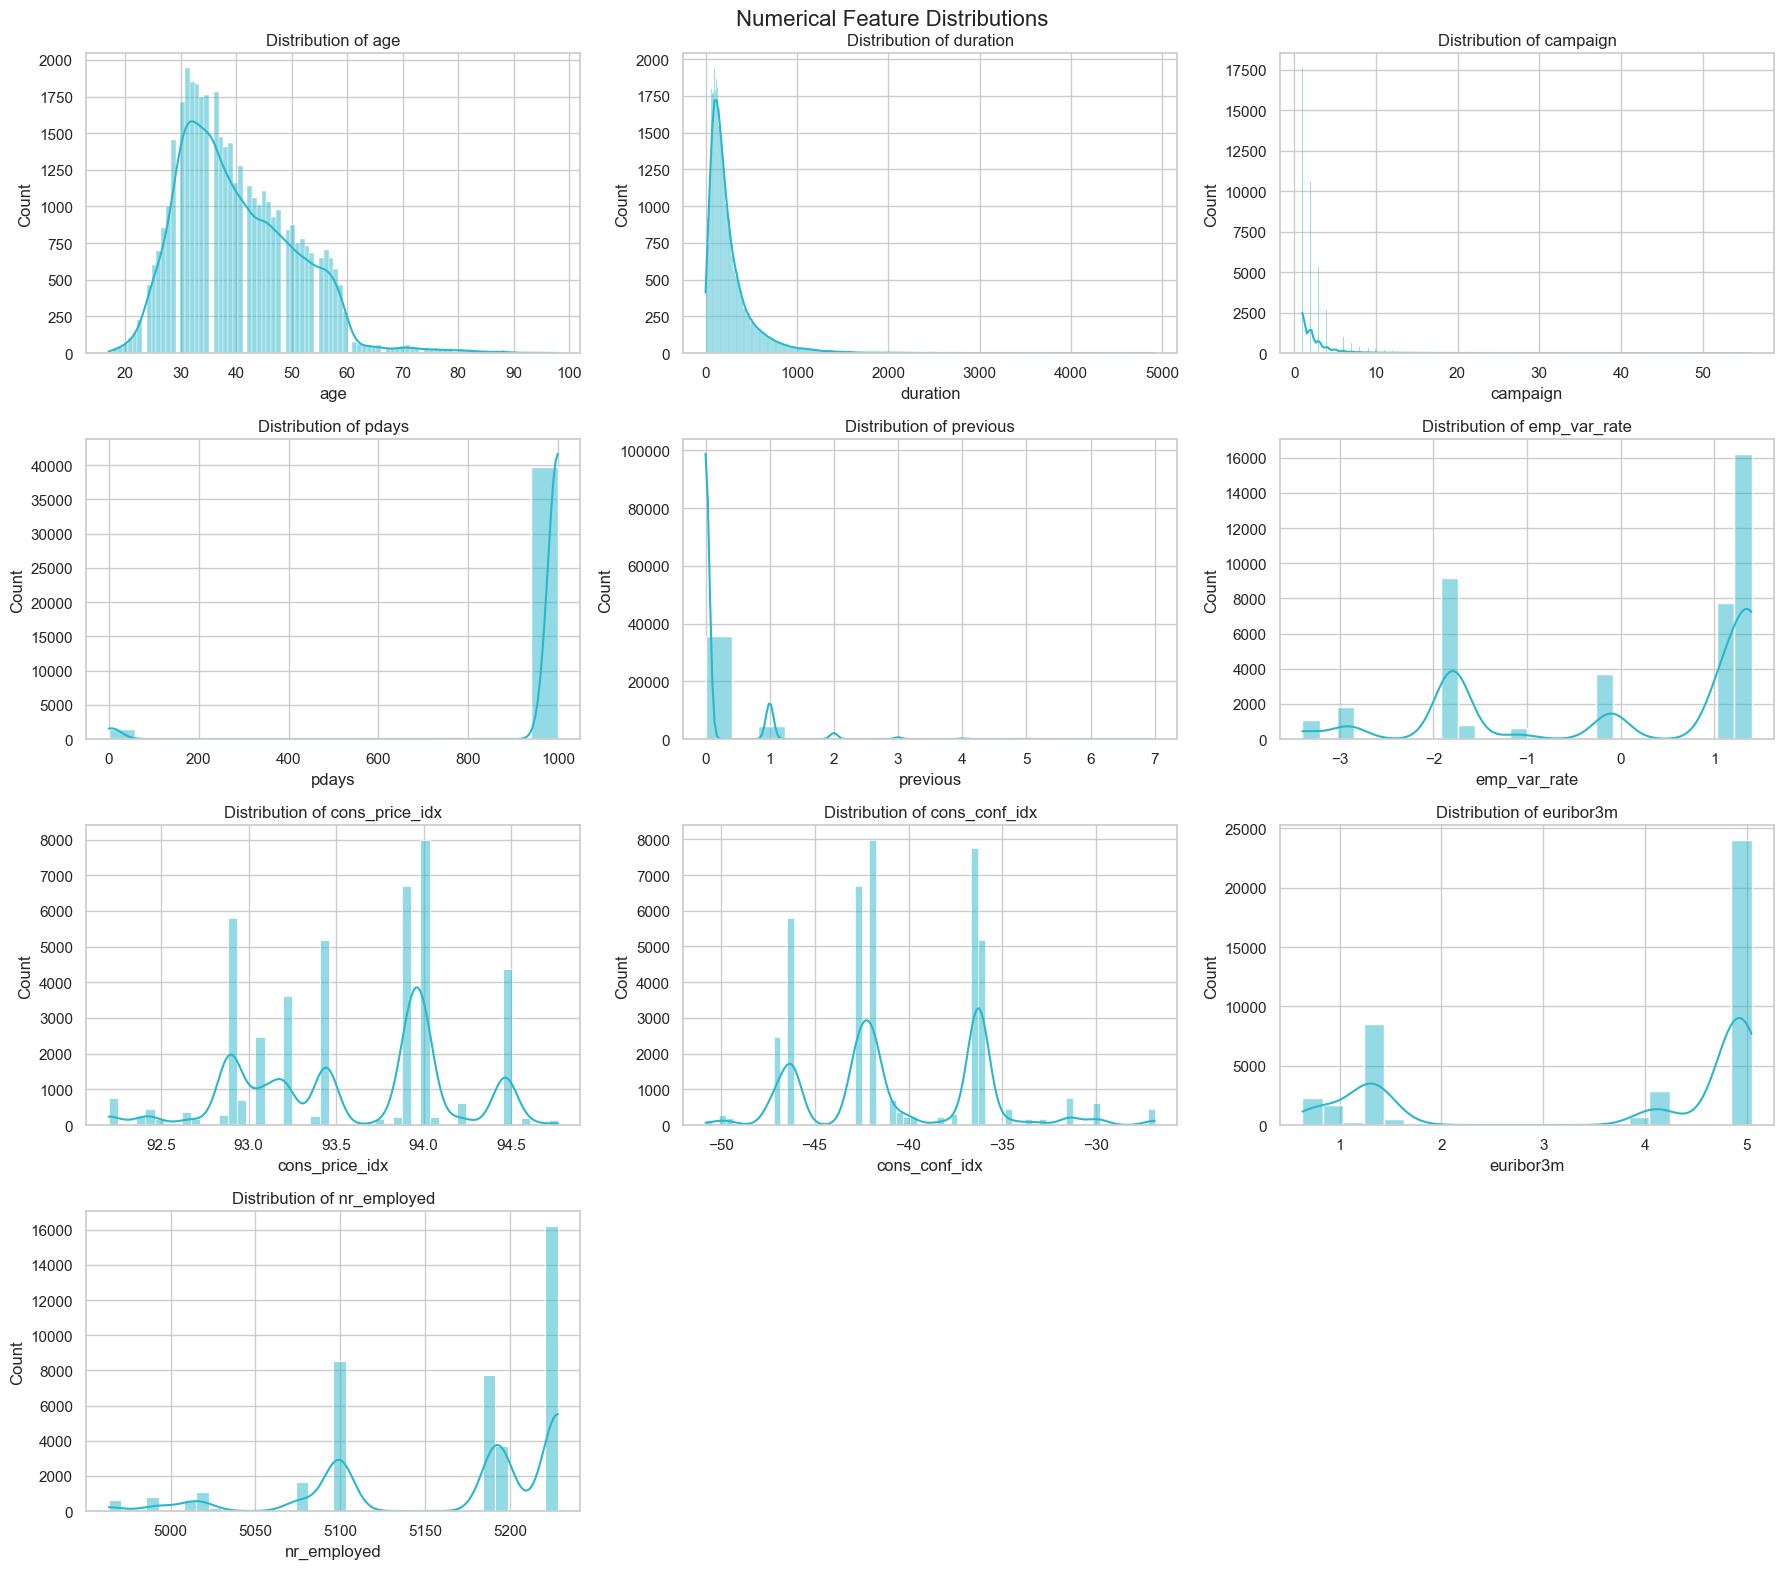

In [35]:
n = len(num_cols)
cols = 3
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color=ACCENT_COLOR)
    axes[i].set_title(f"Distribution of {col}")

# Clear unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Numerical Feature Distributions", fontsize=16)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}all_numeric_histograms.png", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
""" for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True,
                  color=ACCENT_COLOR)
    plt.title(f"Distribution of {col}")

    plt.savefig(f"{FIG_DIR}{col}_distribution.png", dpi=300, bbox_inches="tight")
    plt.show() """

' for col in num_cols:\n    plt.figure(figsize=(8,4))\n    sns.histplot(df[col], kde=True,\n                  color=ACCENT_COLOR)\n    plt.title(f"Distribution of {col}")\n\n    plt.savefig(f"{FIG_DIR}{col}_distribution.png", dpi=300, bbox_inches="tight")\n    plt.show() '

#### Boxplots for Numerical Variables

**Objective:** Boxplots highlight the central tendency, spread, and outliers within each numerical feature. This information will help guide transformations and outlier handling.

**Key aspects to look for:**
- Potential outliers
- Skewed variables that may need transformation
- Variables with limited variability (low information)
- Indicators of customers with unusual behaviors

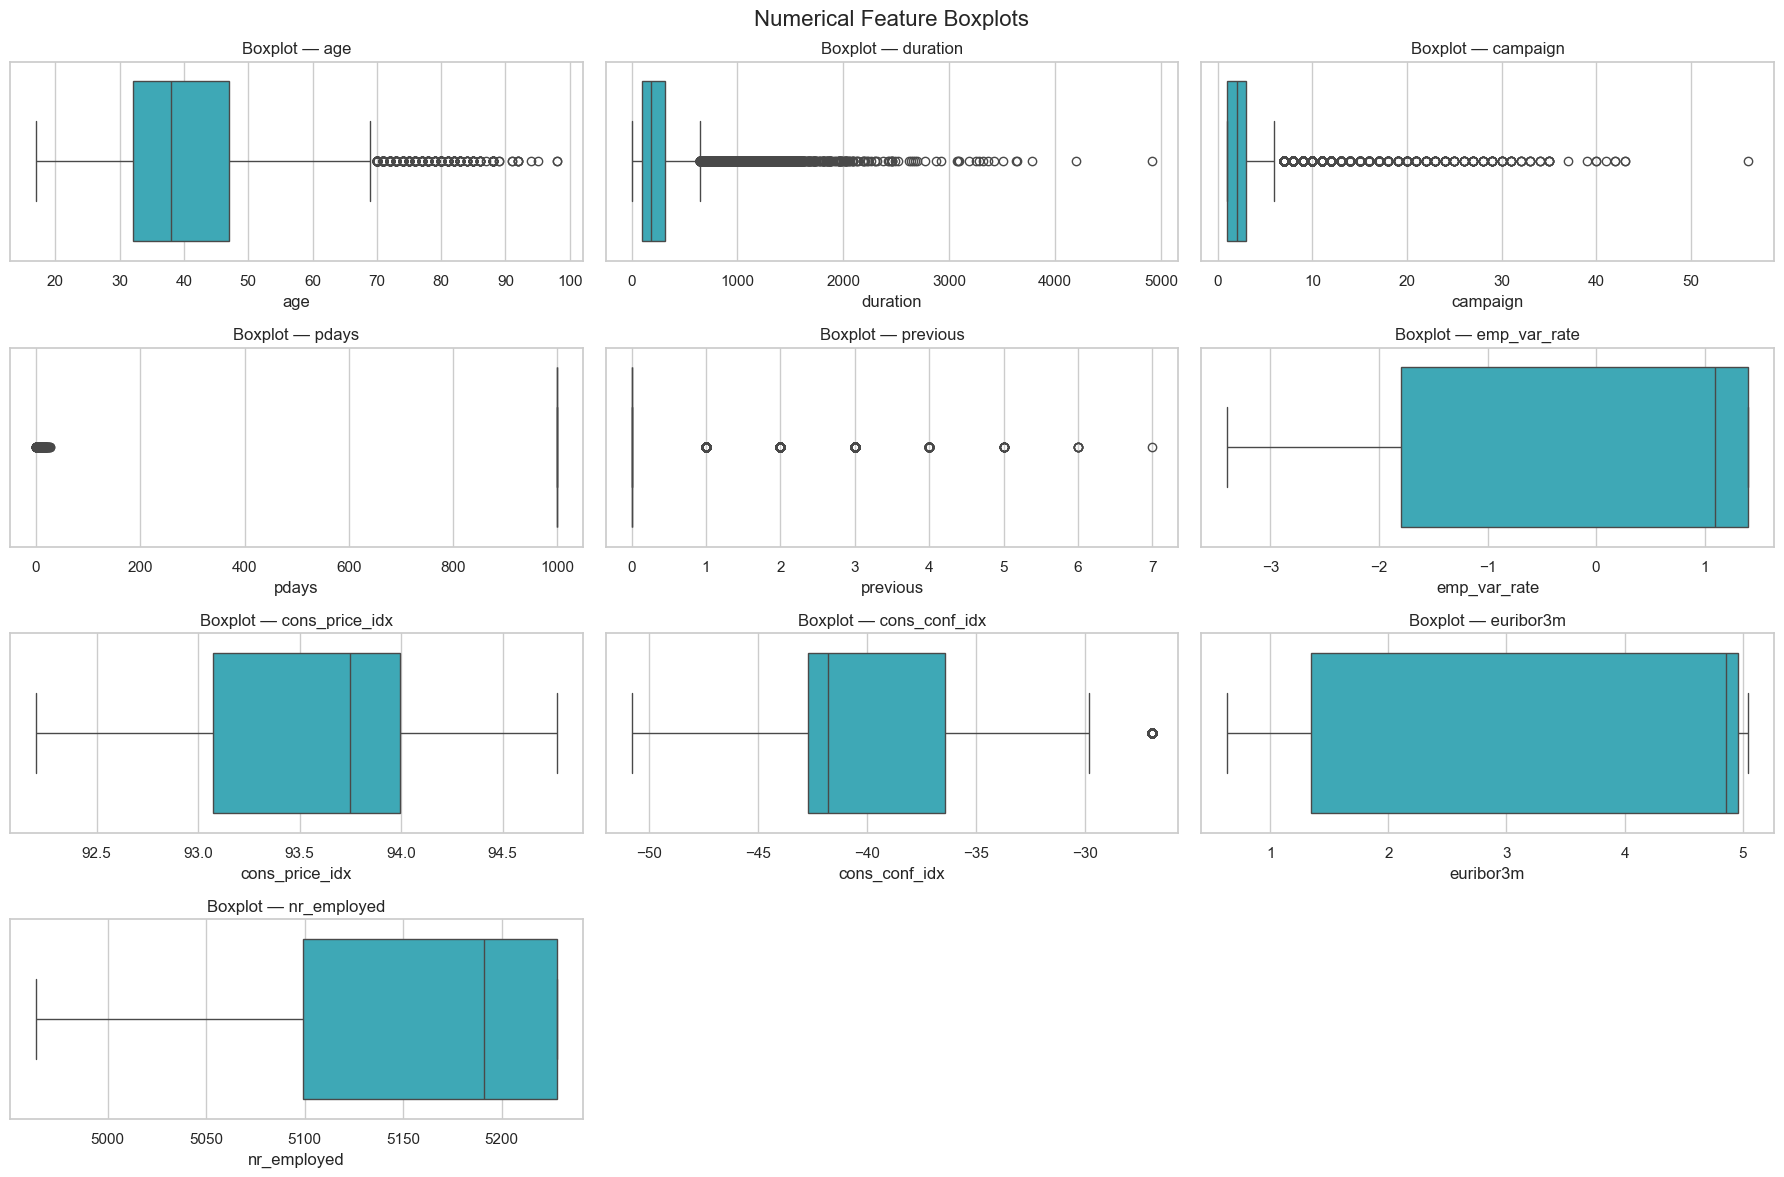

In [37]:
n = len(num_cols)
cols = 3
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i], color=ACCENT_COLOR)
    axes[i].set_title(f"Boxplot — {col}")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Numerical Feature Boxplots", fontsize=16)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}all_numeric_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

In [38]:
""" for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df[col],
                  color=ACCENT_COLOR)
    plt.title(f"Boxplot — {col}")

    plt.savefig(f"{FIG_DIR}{col}_boxplot.png", dpi=300, bbox_inches="tight")
    plt.show() """

' for col in num_cols:\n    plt.figure(figsize=(7,4))\n    sns.boxplot(x=df[col],\n                  color=ACCENT_COLOR)\n    plt.title(f"Boxplot — {col}")\n\n    plt.savefig(f"{FIG_DIR}{col}_boxplot.png", dpi=300, bbox_inches="tight")\n    plt.show() '

#### Categorical Feature Counts

**Objective:** Examine the distribution of each categorical variable, such as job type, marital status, contact method, and education level. Understanding category frequencies will be essential for effective encoding and segmentation.

**Key aspects to look for:**
- Imbalanced categories that may influence modeling
- “Unknown” categories — whether they behave differently or should be imputed
- Rare categories that may need consolidation
- Dominant customer groups that shape campaign focus

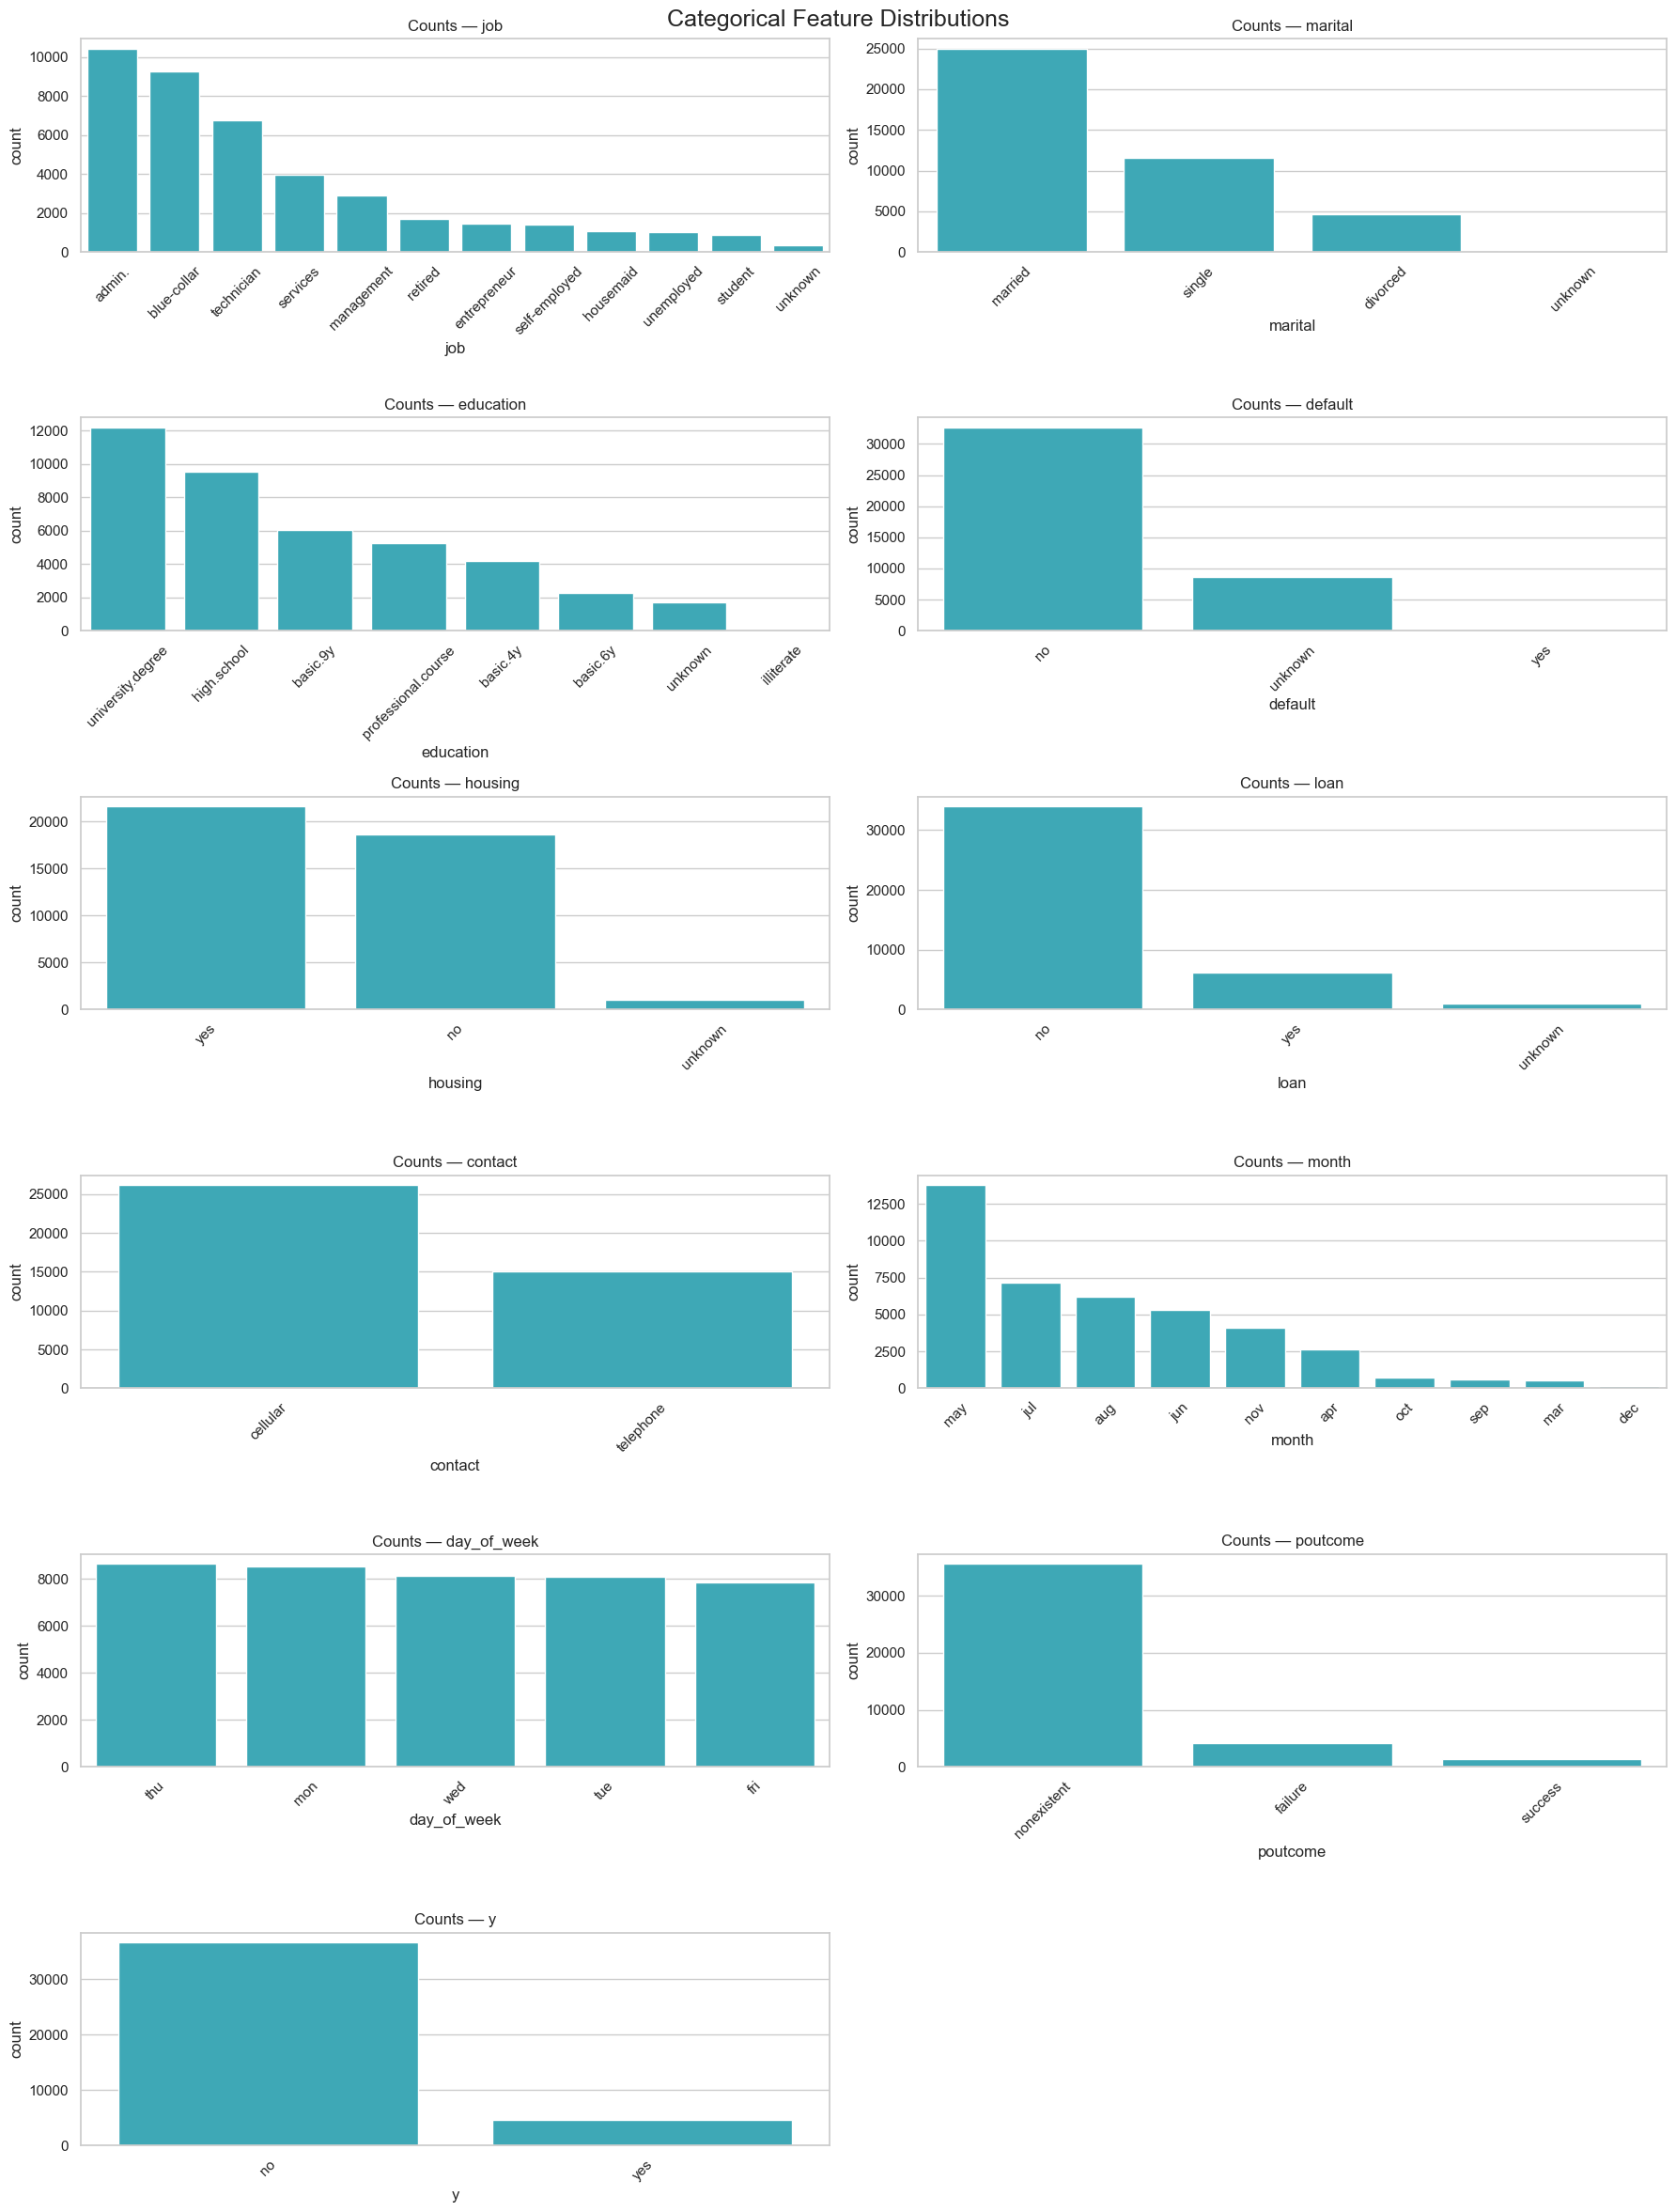

In [39]:
n = len(cat_cols)
cols = 2
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index,
                  ax=axes[i], color=ACCENT_COLOR)
    axes[i].set_title(f"Counts — {col}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Categorical Feature Distributions", fontsize=18)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}all_categorical_counts.png", dpi=300, bbox_inches="tight")
plt.show()

In [40]:
""" for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index,
                  color=ACCENT_COLOR)
    plt.xticks(rotation=45)
    plt.title(f"Value Counts — {col}")

    plt.savefig(f"{FIG_DIR}{col}_value_counts.png", dpi=300, bbox_inches="tight")
    plt.show() """

' for col in cat_cols:\n    plt.figure(figsize=(10,4))\n    sns.countplot(data=df, x=col, order=df[col].value_counts().index,\n                  color=ACCENT_COLOR)\n    plt.xticks(rotation=45)\n    plt.title(f"Value Counts — {col}")\n\n    plt.savefig(f"{FIG_DIR}{col}_value_counts.png", dpi=300, bbox_inches="tight")\n    plt.show() '

### Bivariate Analysis

#### Success Rate by Categorical Features

**Objective:**
Use barplots to show the mean subscription rate (`y_bin`) across categories for each categorical variable. This will help reveal which customer groups are more likely to subscribe, and will help identify key categorical predictors for the model.

**Key aspects to look for:**
- Categories with significantly higher success rates
- Categories with consistently low conversion
- Patterns suggesting strong segmentation opportunities for marketing strategies
- Variables where class imbalance may affect modeling

In [41]:
df["y_bin"] = df["y"].map({"yes":1, "no":0})

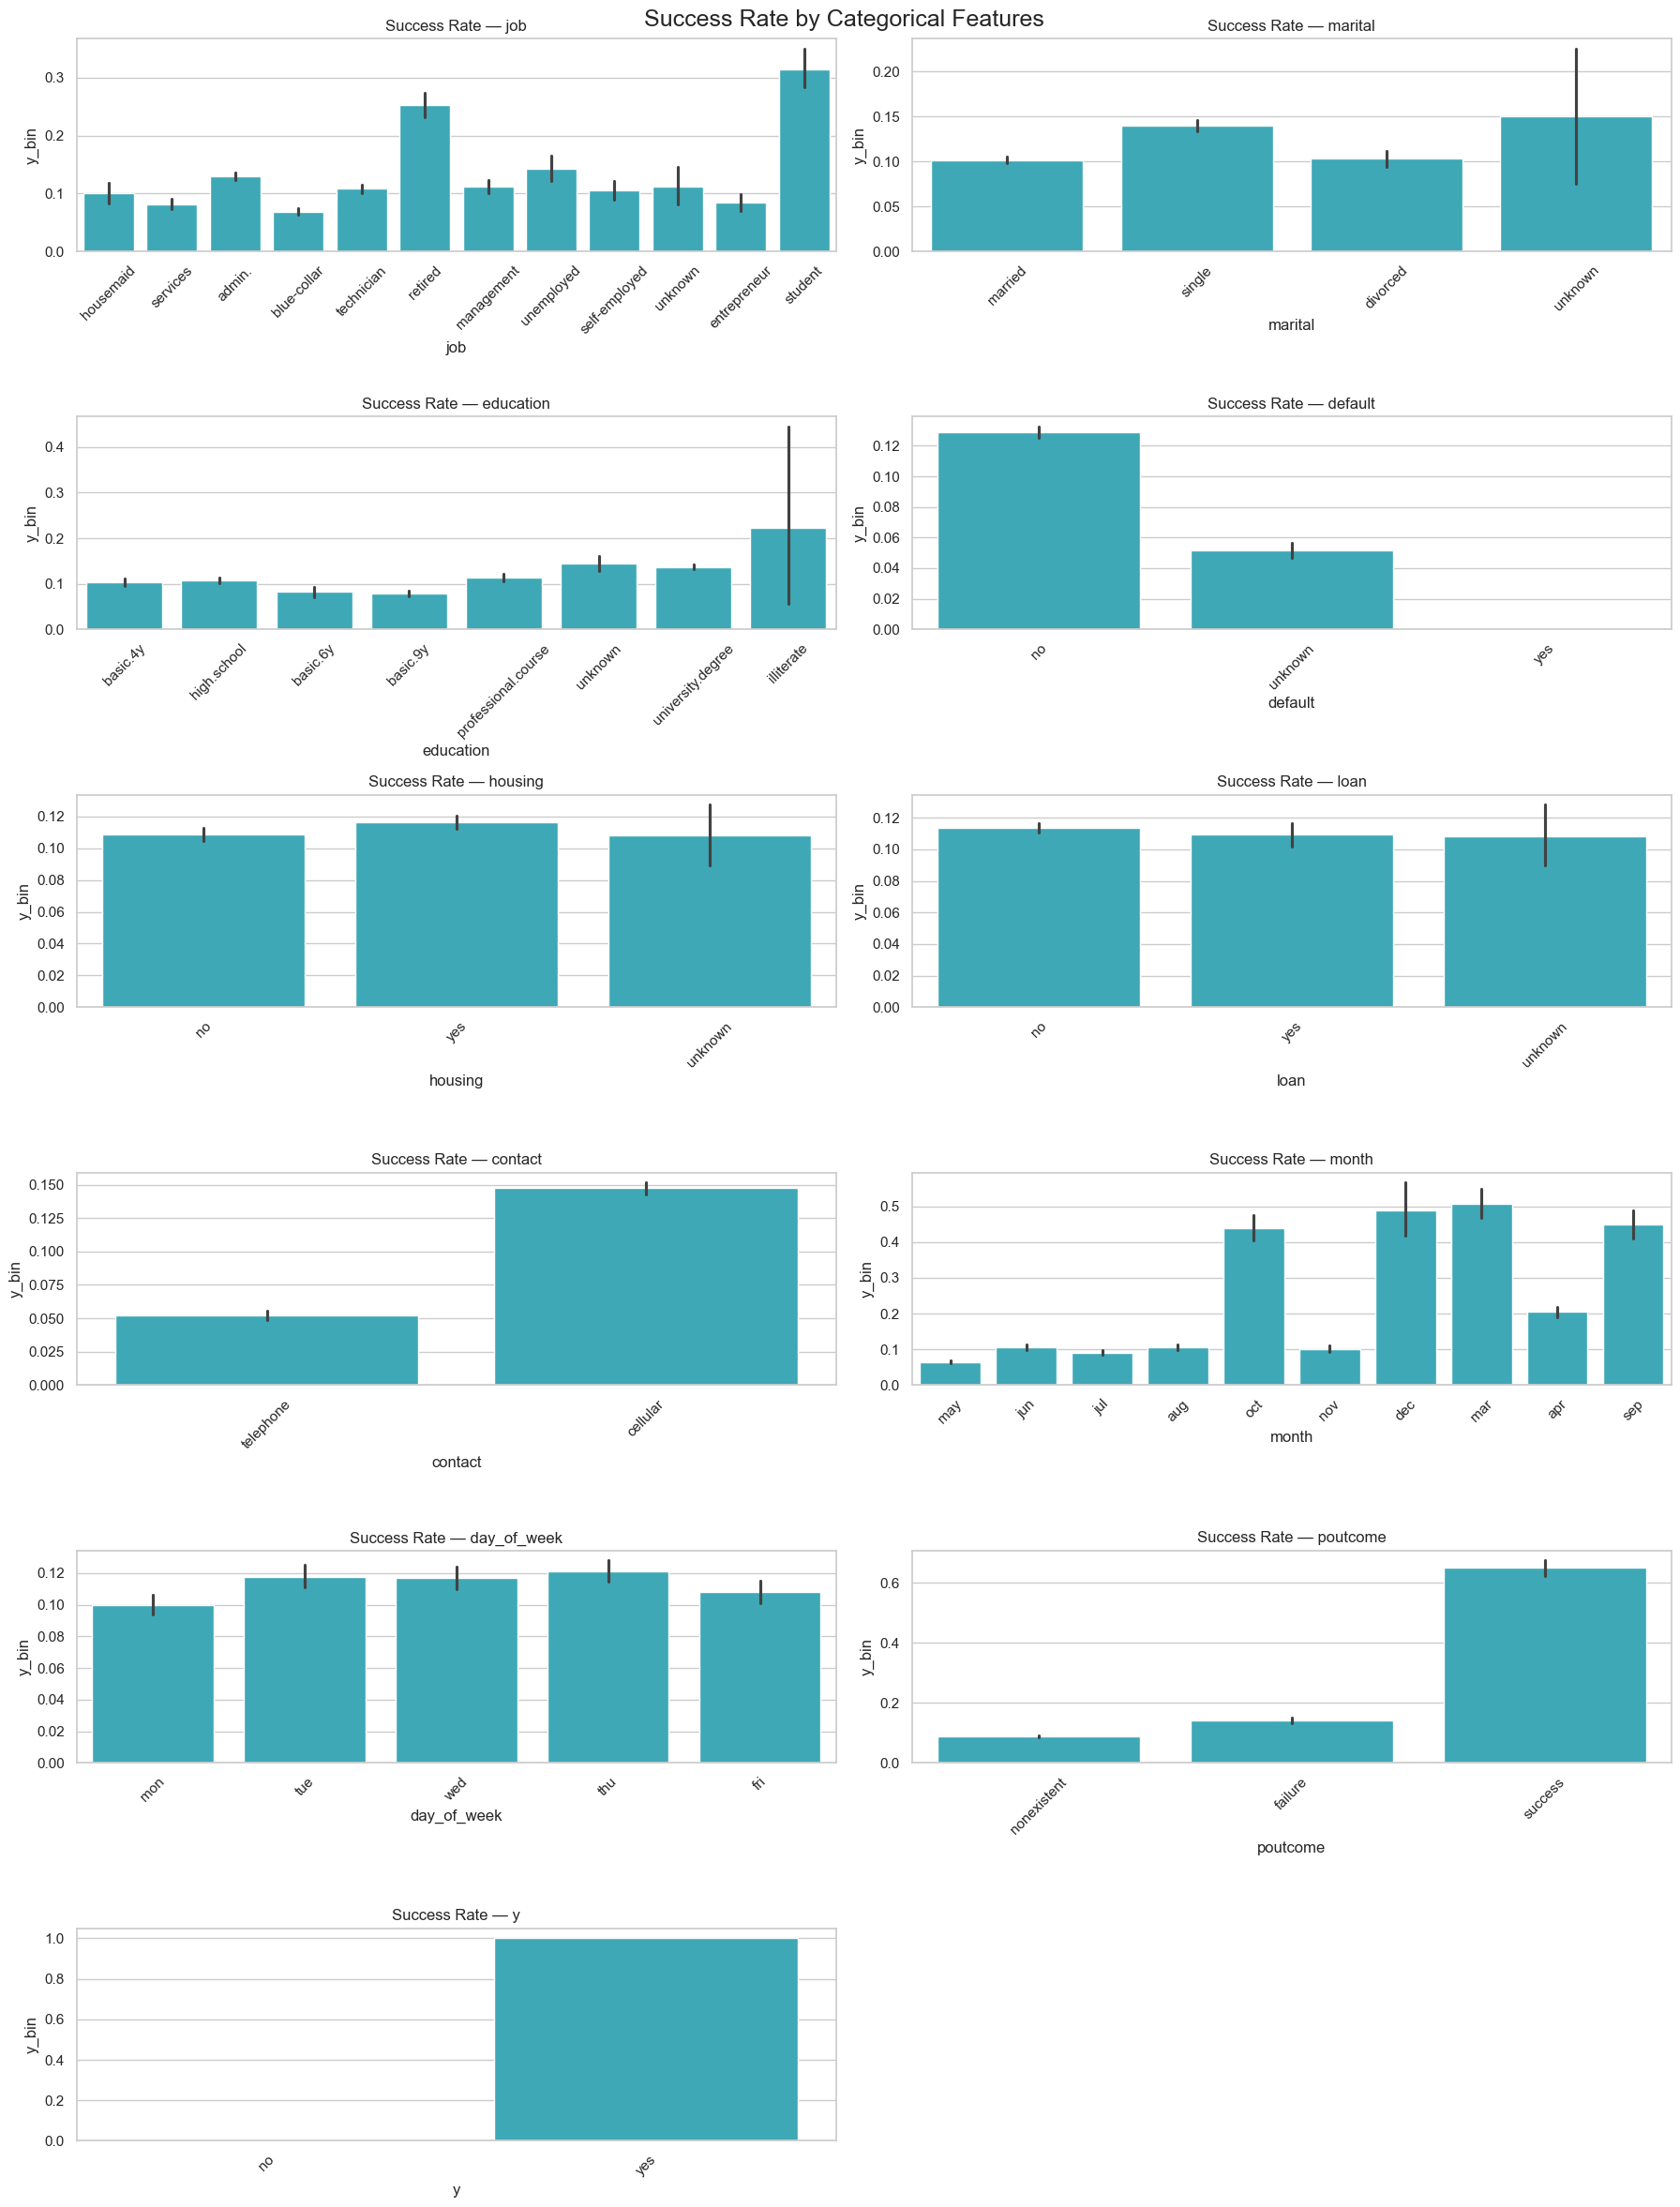

In [42]:
n = len(cat_cols)
cols = 2
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.barplot(data=df, x=col, y="y_bin", ax=axes[i], color=ACCENT_COLOR)
    axes[i].set_title(f"Success Rate — {col}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Success Rate by Categorical Features", fontsize=18)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}all_categorical_success_rates.png", dpi=300, bbox_inches="tight")
plt.show()

In [43]:
""" for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.barplot(x=col, y="y_bin", data=df, color=ACCENT_COLOR)
    plt.xticks(rotation=45)
    plt.title(f"Success Rate by {col}")

    plt.savefig(f"{FIG_DIR}{col}_success_rate.png", dpi=300, bbox_inches="tight")
    plt.show() """

' for col in cat_cols:\n    plt.figure(figsize=(10,4))\n    sns.barplot(x=col, y="y_bin", data=df, color=ACCENT_COLOR)\n    plt.xticks(rotation=45)\n    plt.title(f"Success Rate by {col}")\n\n    plt.savefig(f"{FIG_DIR}{col}_success_rate.png", dpi=300, bbox_inches="tight")\n    plt.show() '

#### Numerical Features vs Target

**Objective:** Use boxplots to compare the distribution of numerical variables across the two target classes (subscribed vs. not subscribed). This analysis will help identify strong numerical predictors.

**Key aspects to look for:**
- Distinct distribution differences
- Variables where the “yes” class is clearly separated from “no”
- Features with little variation across classes (likely low predictive power)
- Outliers that may skew model performance

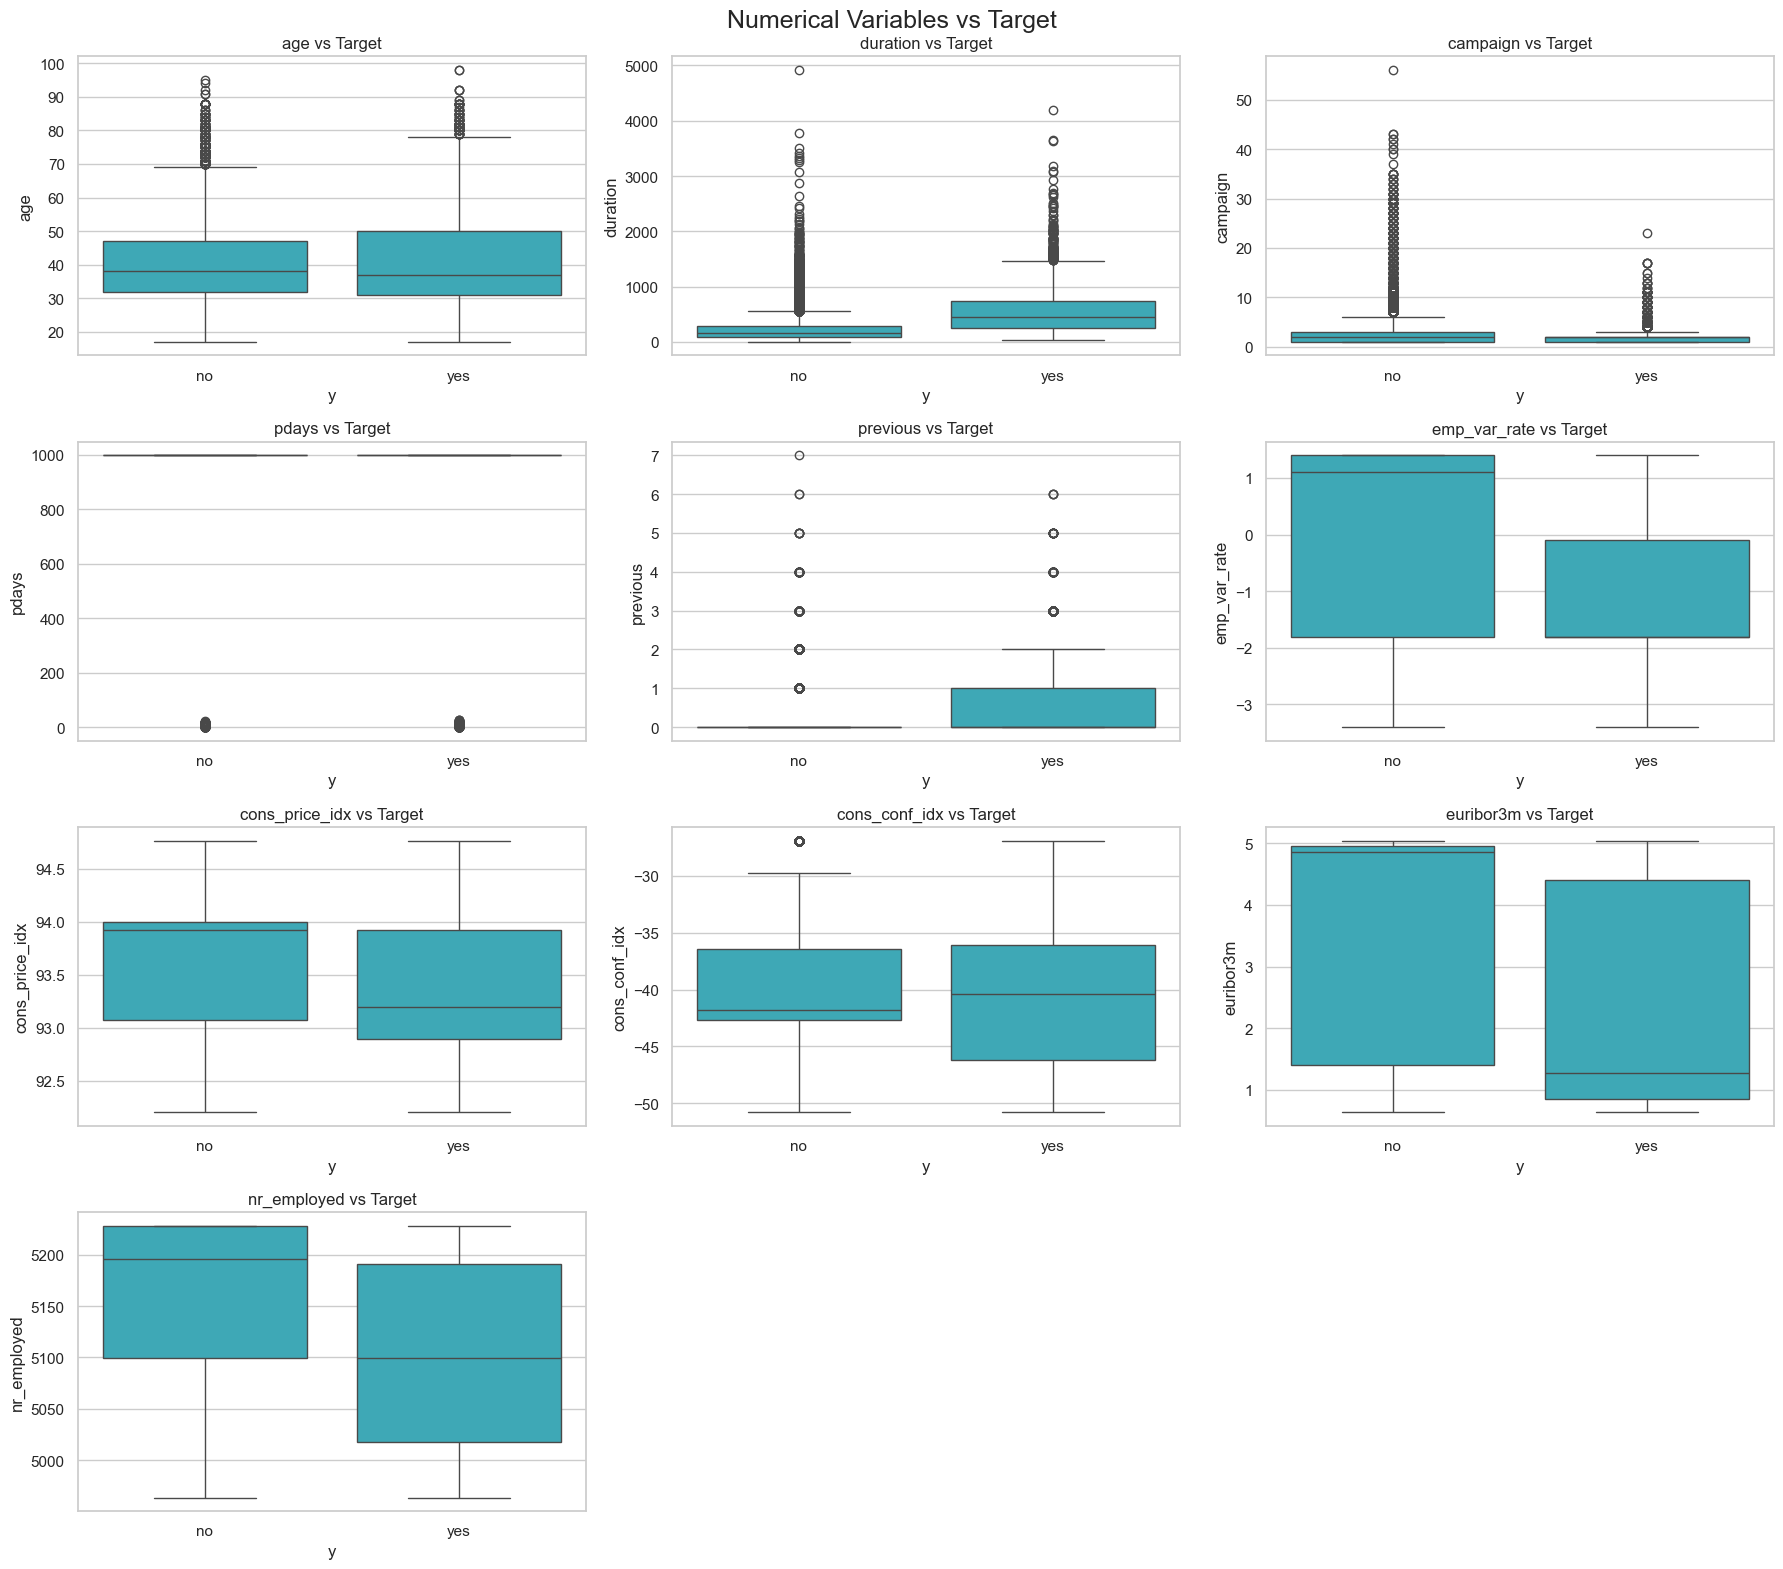

In [44]:
n = len(num_cols)
cols = 3
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x="y", y=col, ax=axes[i], color=ACCENT_COLOR)
    axes[i].set_title(f"{col} vs Target")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Numerical Variables vs Target", fontsize=18)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}all_numeric_vs_target.png", dpi=300, bbox_inches="tight")
plt.show()

In [45]:
""" for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x="y", y=col, color=ACCENT_COLOR)
    plt.title(f"{col} vs Target")

    plt.savefig(f"{FIG_DIR}{col}_vs_target.png", dpi=300, bbox_inches="tight")
    plt.show() """

' for col in num_cols:\n    plt.figure(figsize=(8,4))\n    sns.boxplot(data=df, x="y", y=col, color=ACCENT_COLOR)\n    plt.title(f"{col} vs Target")\n\n    plt.savefig(f"{FIG_DIR}{col}_vs_target.png", dpi=300, bbox_inches="tight")\n    plt.show() '

#### Correlation Heatmap — Numerical Variables

**Objective:** Use a heatmap to visualizes how numerical features correlate with one another. Cells with correlation values above 0.70 (excluding 1.0) are highlighted. This step will further support feature selection and model stability, by understanting which variables might introduce redundancy.

**Key aspects to look for:**
- Strong correlations that may indicate multicollinearity
- Economic indicators that move together
- Redundant features that may need removal
- Unexpected relationships between campaign variables

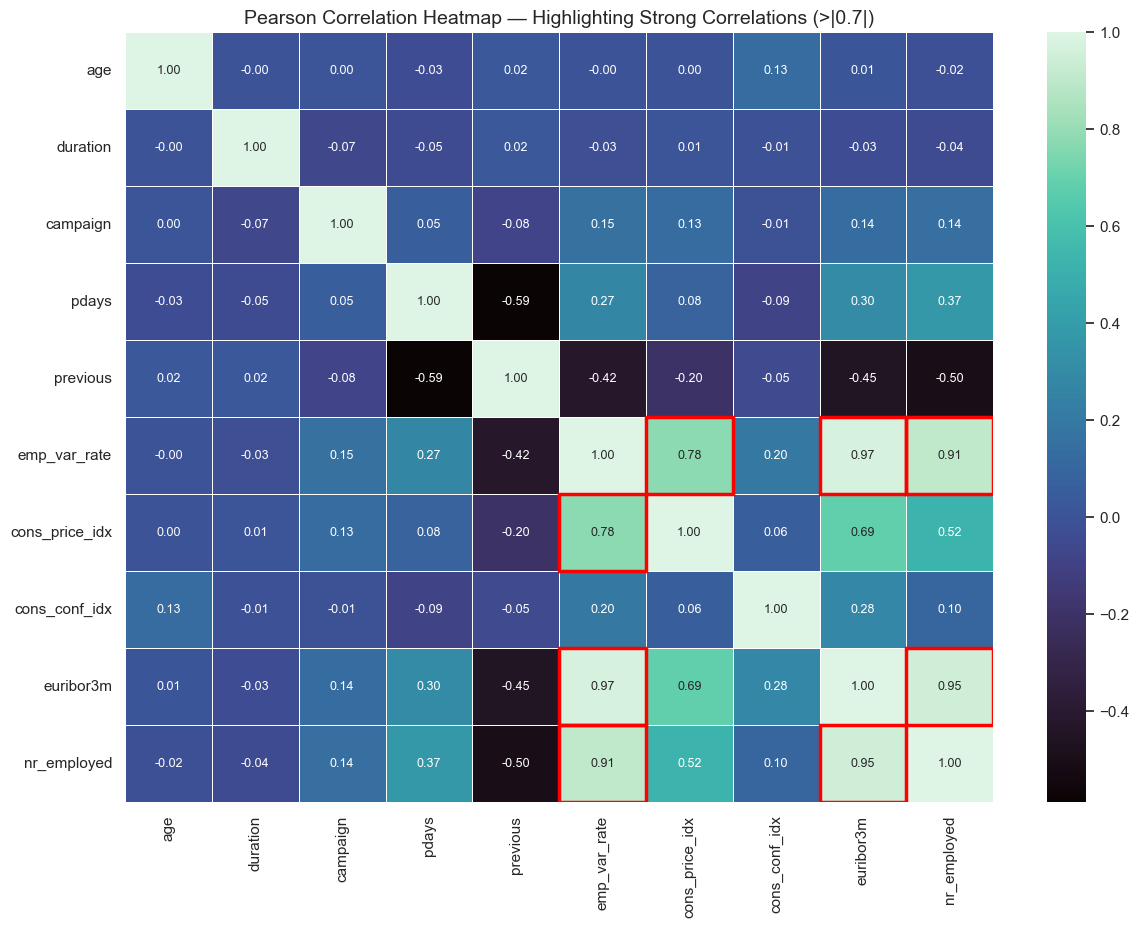

In [46]:
# --- Correlation Matrix ---
corr = df[num_cols].corr()

# --- Mask for highlighting strong correlations ---
# Highlight: |corr| > 0.7 AND corr != 1
highlight_mask = corr.abs() > 0.7
np.fill_diagonal(highlight_mask.values, False)   # prevent self-correlation highlight

plt.figure(figsize=(14,10))

# --- Base heatmap (mako palette) ---
sns.heatmap(
    corr,
    cmap="mako",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar=True,
    annot_kws={"size": 9}
)

# --- Overlay highlight boxes ---
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if highlight_mask.iloc[i, j]:
            plt.gca().add_patch(
                plt.Rectangle(
                    (j, i), 1, 1,
                    fill=False,
                    edgecolor="#ff0000",   # greenish-blue highlight
                    linewidth=2.5
                )
            )

plt.title("Pearson Correlation Heatmap — Highlighting Strong Correlations (>|0.7|)", fontsize=14)

plt.savefig(f"{FIG_DIR}correlation_heatmap_highlighted.png", dpi=300, bbox_inches="tight")
plt.show()


#### Cramér’s V Heatmap — Categorical Variable Associations

**Objective:** Use the Cramér’s V to measure association strength between categorical variables (0 = none, 1 = strong). Cells with values above 0.30 are highlighted. This step will further support feature selection and model stability, by understanting which variables might introduce redundancy.

**Key aspects to look for:**
- Categorical variables that encode similar information
- Redundant or strongly dependent features
- Pairs of categories that interact meaningfully
- Opportunities for feature grouping or simplification

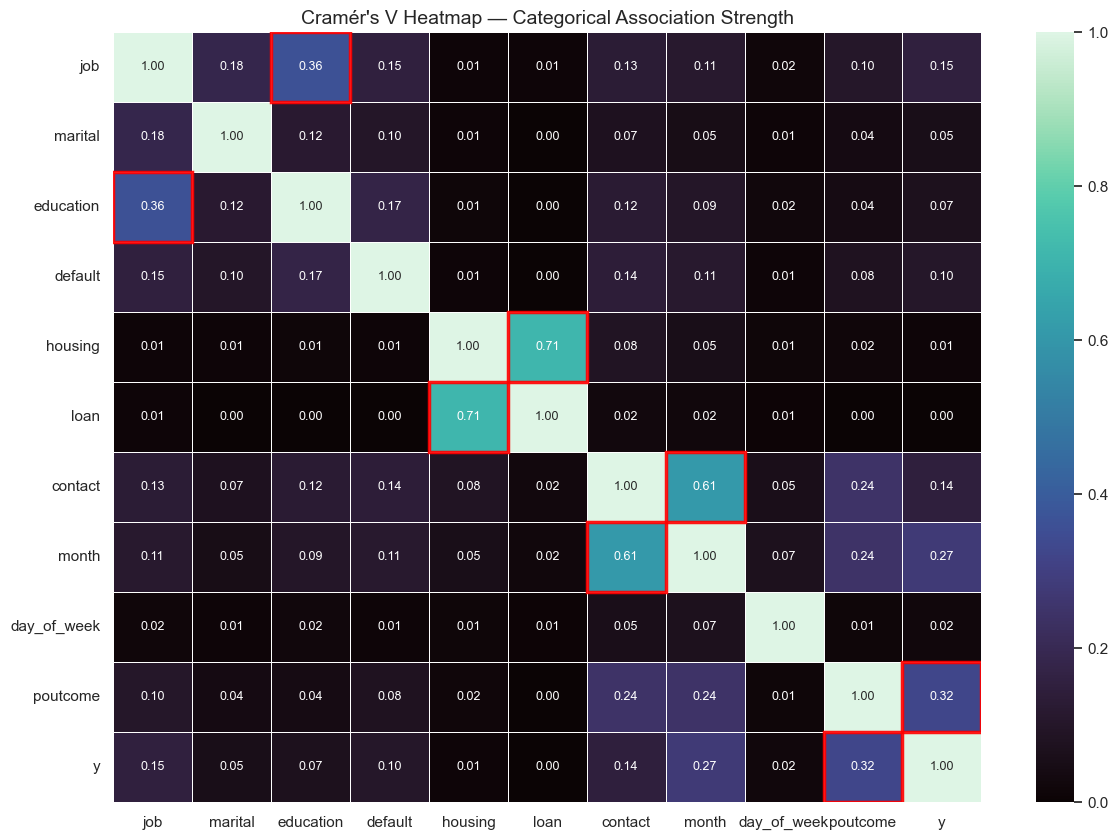

In [47]:
# --- Function to compute Cramér's V ---
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# --- Compute Cramér's V matrix ---
cat_corr = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cat_corr.loc[col1, col2] = cramers_v(df[col1], df[col2])

# --- Mask for highlighting strong associations ---
highlight_mask = cat_corr.abs() > 0.30   # threshold for moderate association
np.fill_diagonal(highlight_mask.values, False)

plt.figure(figsize=(14,10))

# --- Base heatmap ---
sns.heatmap(
    cat_corr,
    cmap="mako",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 9},
    cbar=True
)

# --- Add teal highlight box for strong associations ---
for i in range(cat_corr.shape[0]):
    for j in range(cat_corr.shape[1]):
        if highlight_mask.iloc[i, j]:
            plt.gca().add_patch(
                plt.Rectangle(
                    (j, i), 1, 1,
                    fill=False,
                    edgecolor="#ff0000ea",  # your greenish-blue highlight
                    linewidth=2.5
                )
            )

plt.title("Cramér's V Heatmap — Categorical Association Strength", fontsize=14)

plt.savefig(f"{FIG_DIR}categorical_cramersV_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

### Segment Analysis

#### Age Group Performance

**Objective:** Group customers into age segments (Young, Adult, Middle Age, Senior), to enable the visualization of subscription rates across age groups.

**Key aspects to look for:**
- Which age groups show the highest likelihood of subscribing
- Whether seniors or younger customers behave differently
- Whether age should be used as a continuous or categorical feature
- Potential targeting opportunities for specific age segments

In [48]:
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 25, 40, 60, 100],
    labels=["Young", "Adult", "Middle Age", "Senior"]
)

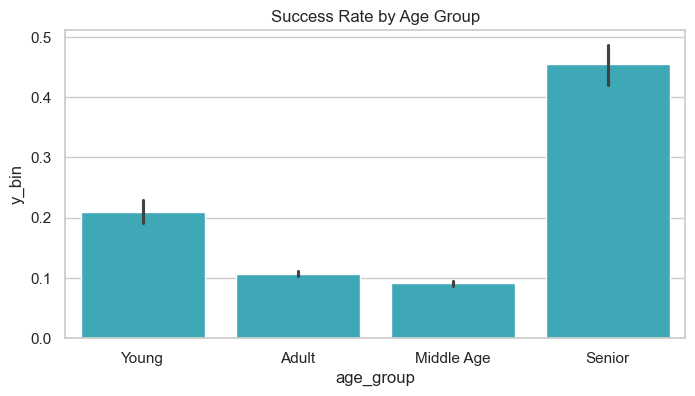

In [49]:
plt.figure(figsize=(8,4))
sns.barplot(data=df, x="age_group", y="y_bin", color=ACCENT_COLOR)
plt.title("Success Rate by Age Group")

plt.savefig(f"{FIG_DIR}age_group_success_rate.png", dpi=300, bbox_inches="tight")
plt.show()

#### Success Rate by Job Category

**Objective:** Group customers into Job type to show conversion rates across job categories.

**Key aspects to look for:**
- High-value groups such as students and retirees
- Low-engagement groups such as blue-collar workers
- Opportunities to tailor campaigns to specific professions
- Job types that may require different outreach strategies

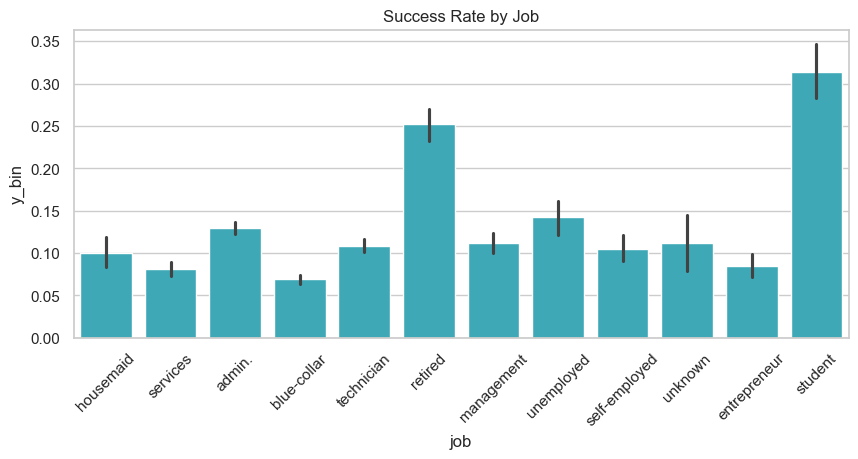

In [50]:
plt.figure(figsize=(10,4))
sns.barplot(data=df, x="job", y="y_bin", color=ACCENT_COLOR)
plt.xticks(rotation=45)
plt.title("Success Rate by Job")

plt.savefig(f"{FIG_DIR}job_success_rate.png", dpi=300, bbox_inches="tight")
plt.show()


#### Success Rate by Month

**Objective:** Check whether marketing success rates vary significantly across months, by highlighting temporal patterns in customer responsiveness.

**Key aspects to look for:**
- Historically strong months
- Seasonal trends that affect campaign planning
- Whether month should be one-hot encoded
- Insights into timing optimization for telemarketing efforts

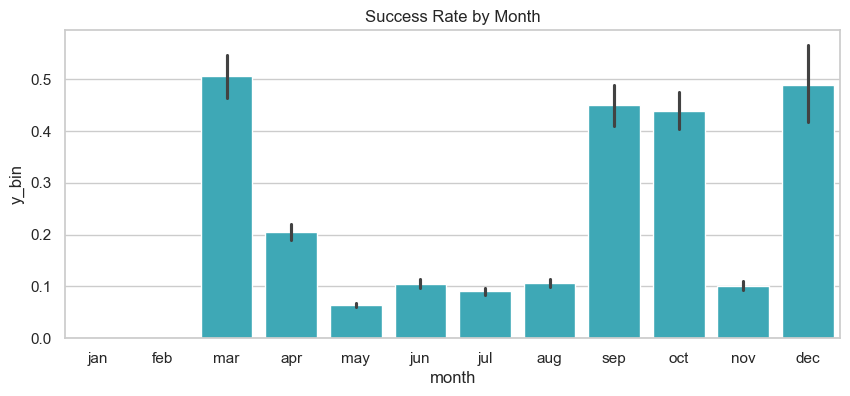

In [51]:
plt.figure(figsize=(10,4))
sns.barplot(
    data=df, x="month", y="y_bin",
    order=["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"],
    color=ACCENT_COLOR
)
plt.title("Success Rate by Month")

plt.savefig(f"{FIG_DIR}month_success_rate.png", dpi=300, bbox_inches="tight")
plt.show()

### Economic Indicators

#### Distribution by Target

**Objective:** Use a set of histograms to compare the distribution of macroeconomic indicators between subscribers and non-subscribers. These insights will be used to check whether economic indicators are influential on conversion.

**Key aspects to look for:**
- Clear separation between target classes
- Economic variables that strongly influence marketing success
- Which indicators may act as leading predictors

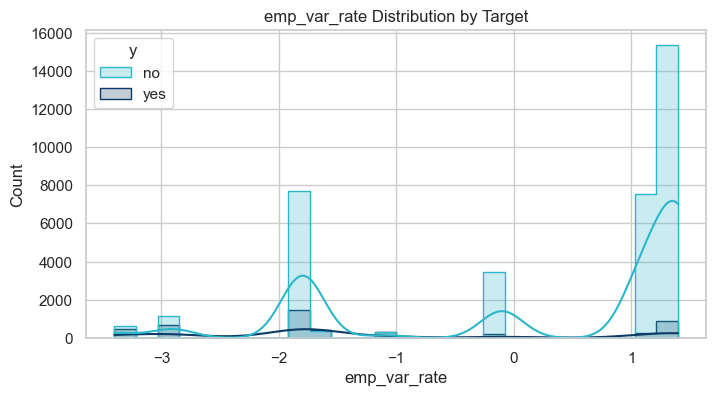

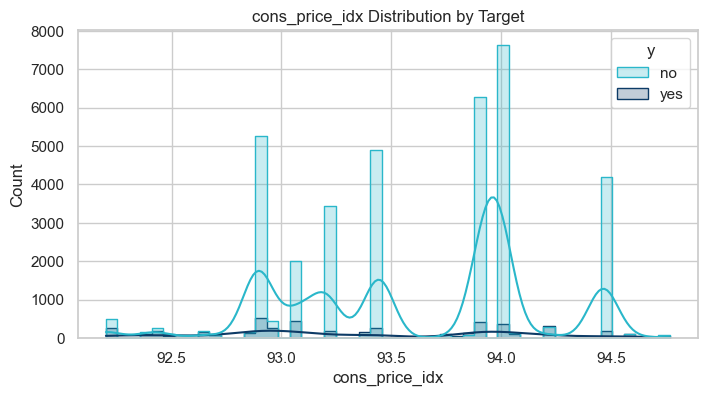

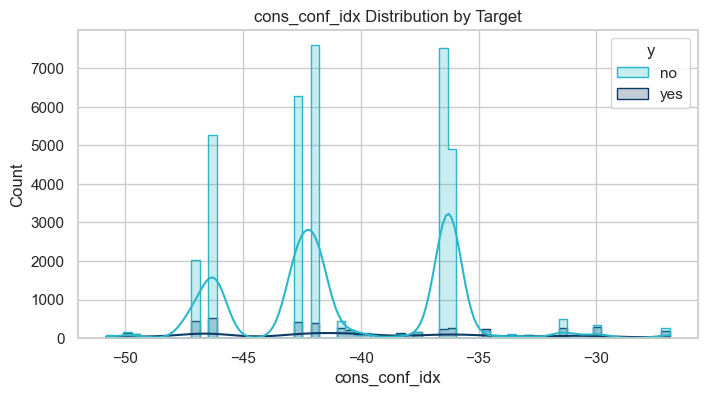

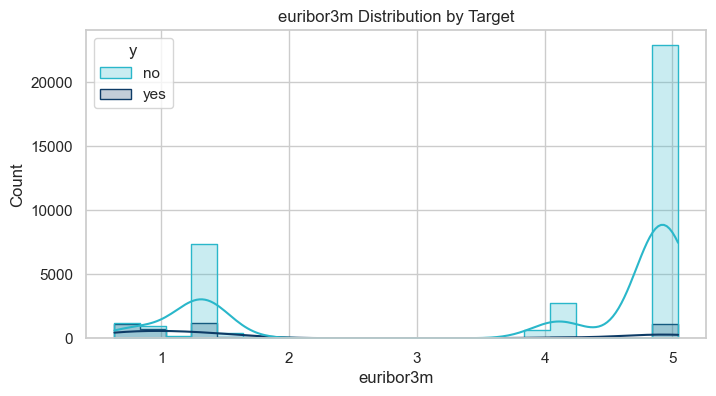

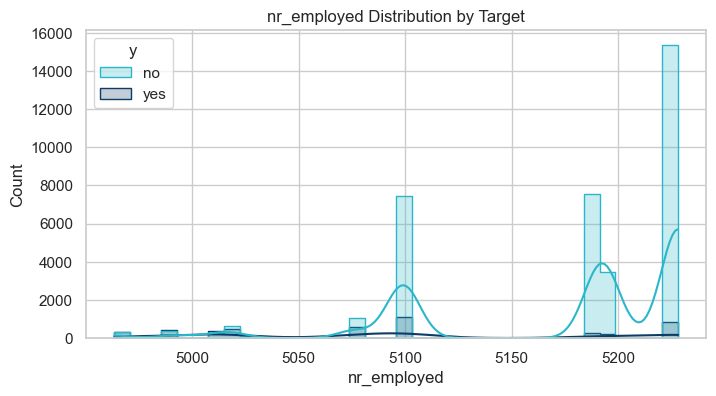

In [52]:
for col in ["emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed"]:
    plt.figure(figsize=(8,4))

    sns.histplot(
        data=df, x=col, hue="y",
        palette=[ACCENT_COLOR, "#0d3b66"],   # teal vs deep blue
        kde=True, element="step"
    )

    plt.title(f"{col} Distribution by Target")

    plt.savefig(f"{FIG_DIR}{col}_vs_target_dist.png", dpi=300, bbox_inches="tight")
    plt.show()


### PariPlots

#### Key Numerical Variables

**Objective:** Use a pairplot to visualize relationships among the main numerical predictors in the dataset. Each scatter plot compares two features, while the diagonal shows KDE distributions for individual variables.

**Key aspects to look for:**
- Whether any variables show clear separation between successful (`yes`) and unsuccessful (`no`) outcomes
- Linear or nonlinear patterns between variables that may be useful for predictive modeling
- Clusters, outliers, or unusual patterns in customer behavior

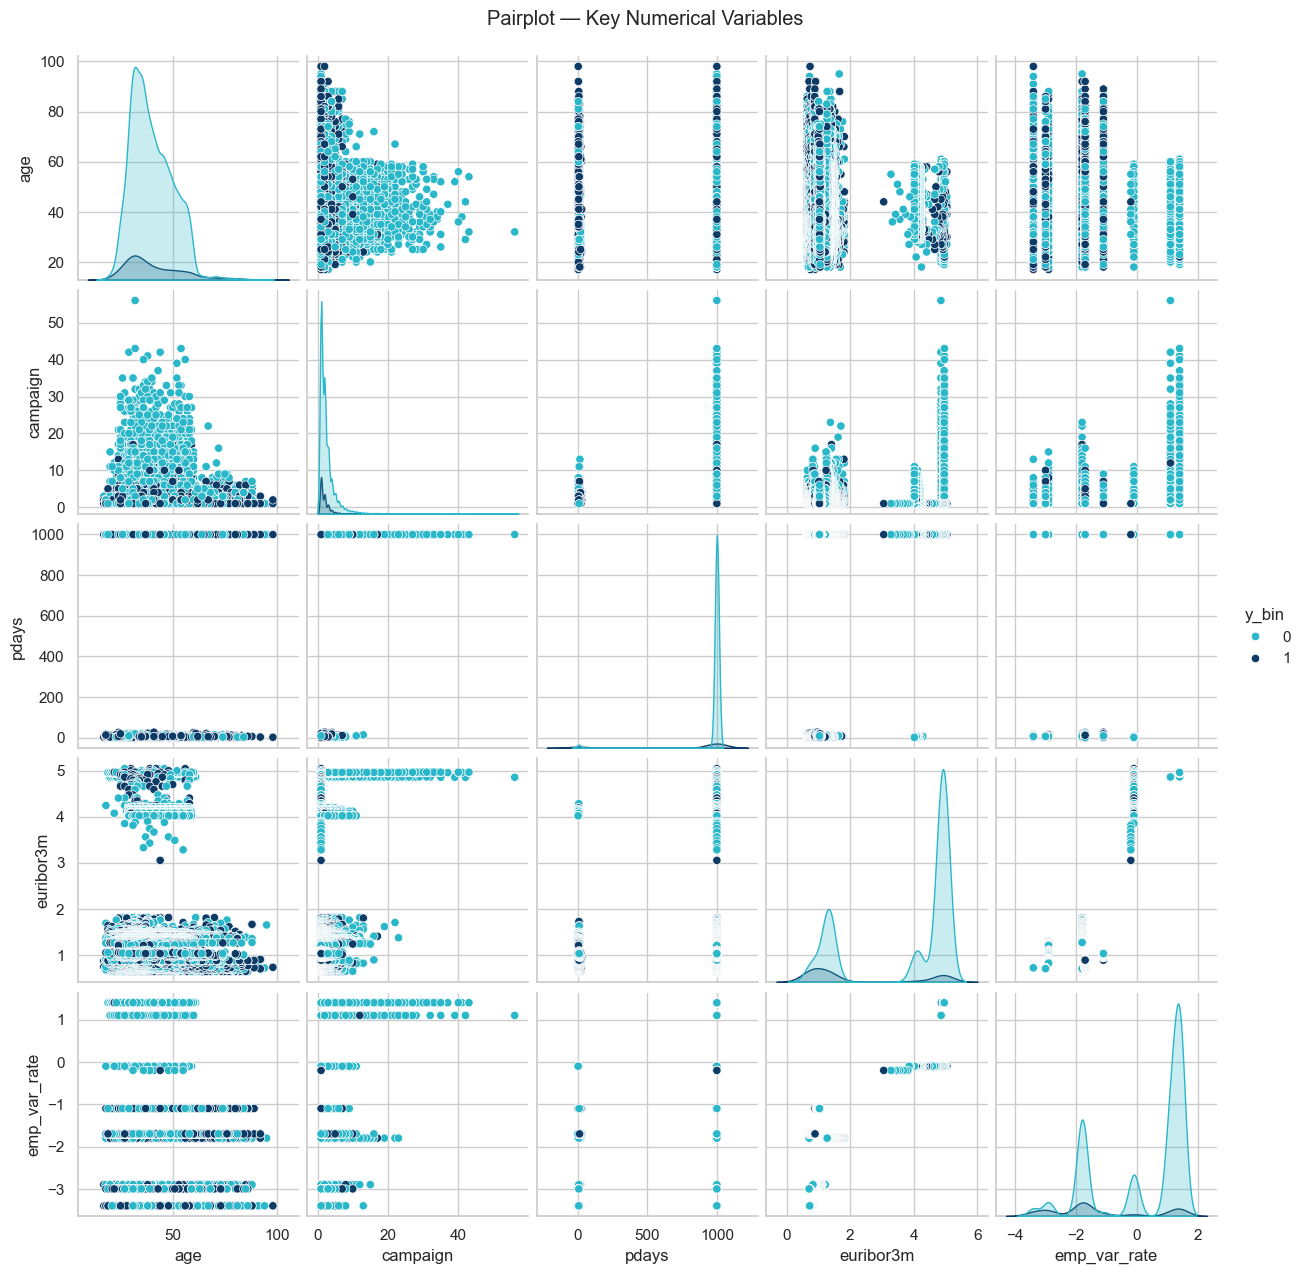

In [53]:
pairplot_cols = [
    "age",
    "campaign",
    "pdays",
    "euribor3m",
    "emp_var_rate",
    "y_bin"
]

g = sns.pairplot(
    df[pairplot_cols],
    hue="y_bin",
    palette={0: ACCENT_COLOR, 1: SECOND_COLOR},
    diag_kind="kde",
    corner=False
)

g.fig.suptitle("Pairplot — Key Numerical Variables", y=1.02)

plt.savefig(f"{FIG_DIR}pairplot_numeric.png", dpi=300, bbox_inches="tight")
plt.show()


#### Economic Indicators

**Objective:** Use a pairplot to analyse the macroeconomic variables included in the dataset, and check whether these variables have a strong influence on client responses to marketing campaigns.

**Key aspects to look for:**
- Whether economic conditions correlate with customer subscription behavior
- Separability between classes (`y_bin`) under different economic contexts.
- Relationships between indicators

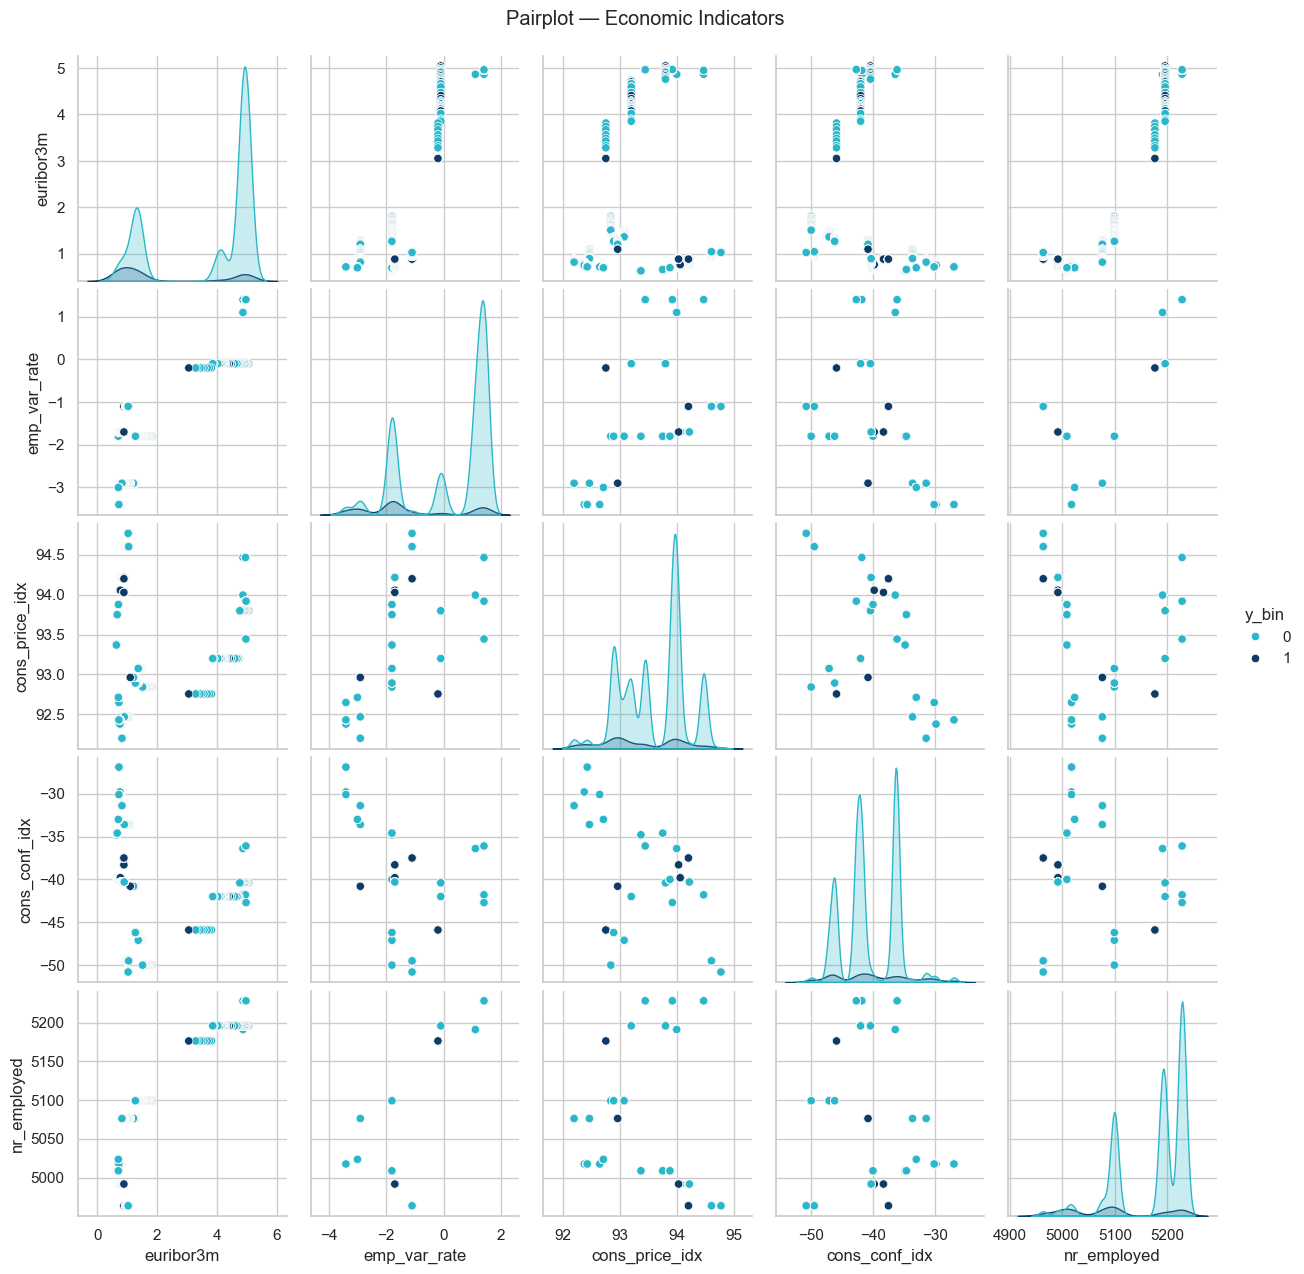

In [54]:
econ_cols = [
    "euribor3m",
    "emp_var_rate",
    "cons_price_idx",
    "cons_conf_idx",
    "nr_employed",
    "y_bin"
]

g = sns.pairplot(
    df[econ_cols],
    hue="y_bin",
    palette={0: ACCENT_COLOR, 1: SECOND_COLOR},
    diag_kind="kde",
    corner=False
)

g.fig.suptitle("Pairplot — Economic Indicators", y=1.02)

plt.savefig(f"{FIG_DIR}pairplot_economic.png", dpi=300, bbox_inches="tight")
plt.show()


### (PairGrid) Regression Relationships

**Objective:** Use a pairgrid to draw regression lines between numeric features, to help identify potential linear relationships and check whether trends differ between the target classes.

**Key aspects to look for:**
- Whether regression lines differ for clients who subscribed vs. those who did not
- Linear predictive patterns
- Whether any features show weak or no linear relationship

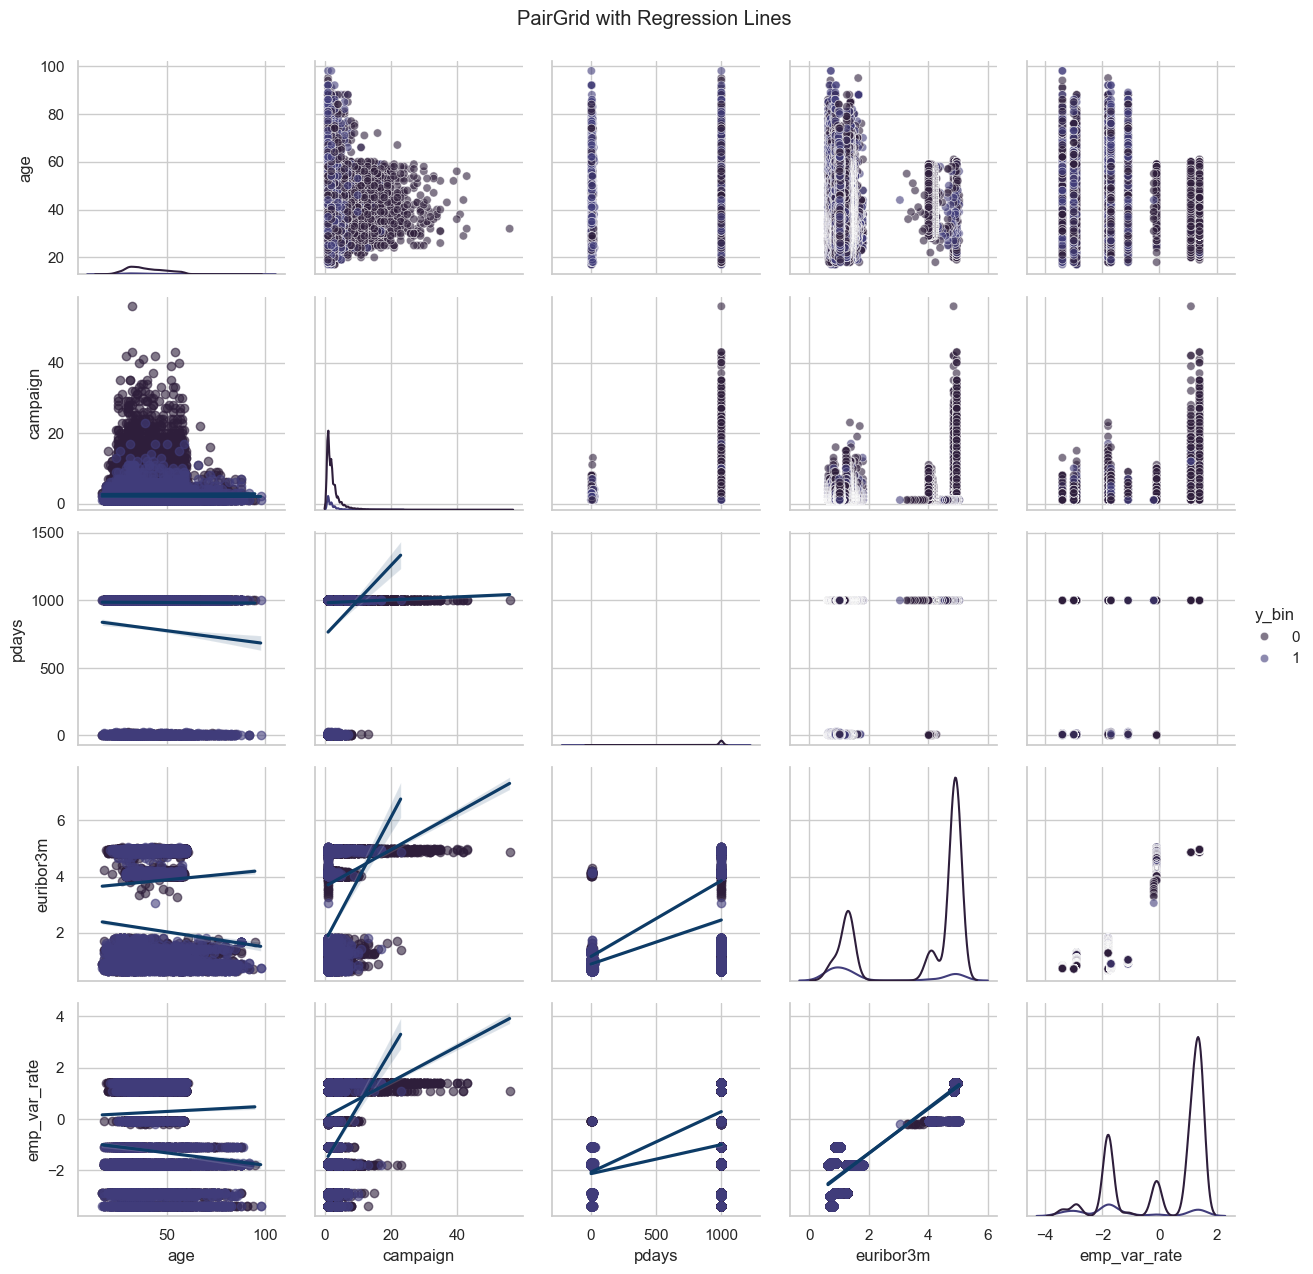

In [55]:
reg_cols = [
    "age",
    "campaign",
    "pdays",
    "euribor3m",
    "emp_var_rate"
]

g = sns.PairGrid(df[reg_cols + ["y_bin"]], hue="y_bin")
g.map_lower(sns.regplot,
            scatter_kws={"alpha": 0.6},
            line_kws={"color": SECOND_COLOR})
g.map_diag(sns.kdeplot)
g.map_upper(sns.scatterplot, alpha=0.6,
            palette={0: ACCENT_COLOR, 1: SECOND_COLOR})

g.add_legend()
g.fig.suptitle("PairGrid with Regression Lines", y=1.02)

plt.savefig(f"{FIG_DIR}pairgrid_regression.png", dpi=300, bbox_inches="tight")
plt.show()


### (Mixed-Type PairGrid) Numerical and Categorical Variables

**Objective:** Use a mixed-type pairgrid plot to check how categorical groups differ across numeric values by including:
- Scatterplots for numeric–numeric relationships  
- Strip plots for categorical–numeric and categorical–categorical combinations  
- KDE plots on the diagonal  

**Key aspects to look for:**
- Whether certain categories (job, marital status, or education) cluster differently across numeric features.
- Categorical groups with distinct distributions (e.g., younger students vs. older retirees).
- Patterns indicating that a categorical variable might be informative for the model.

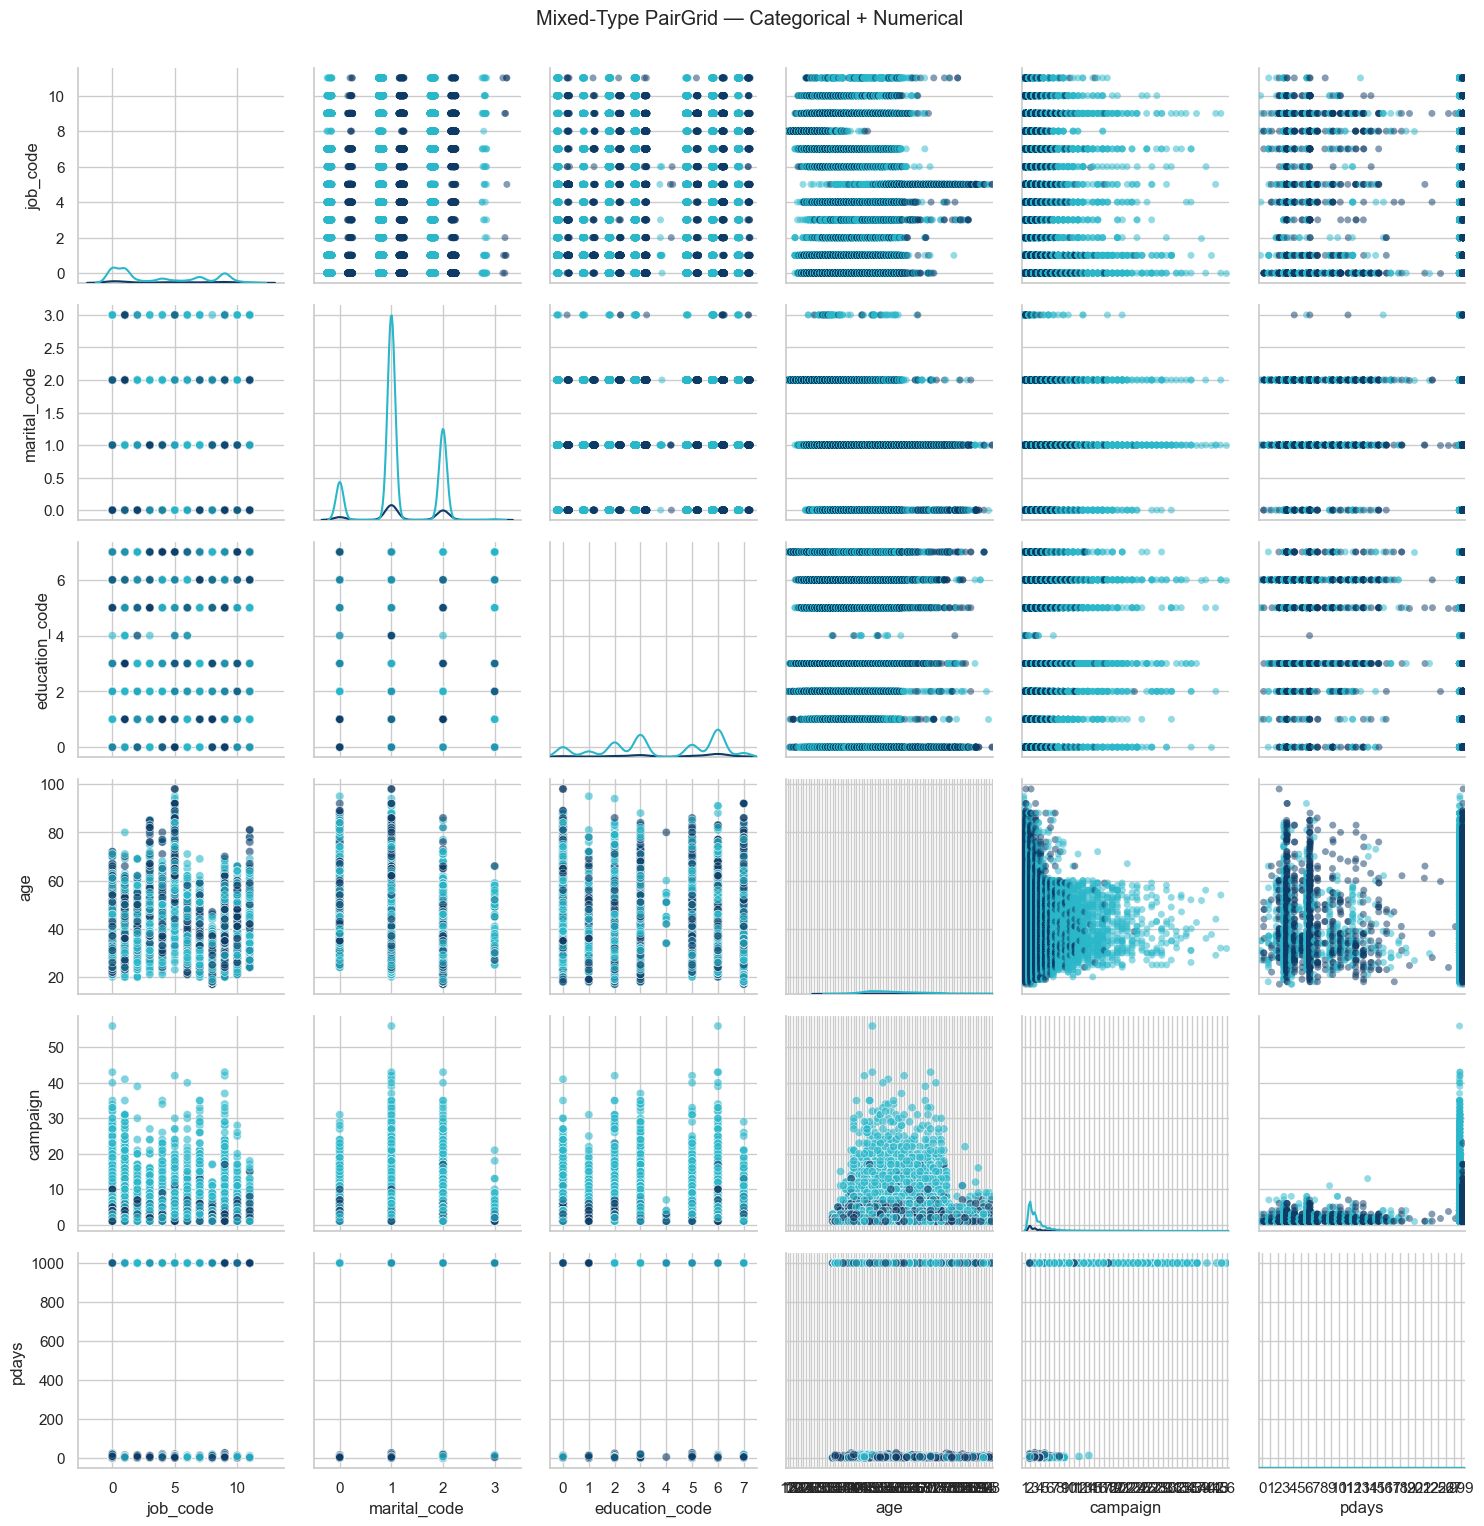

In [56]:
# Choose a subset of categorical + numeric features
cat_subset = ["job", "marital", "education"]
num_subset = ["age", "campaign", "pdays"]

# Encode categories to integers for plotting
df_coded = df.copy()
for col in cat_subset:
    df_coded[col + "_code"] = df_coded[col].astype("category").cat.codes

mix_cols = [col + "_code" for col in cat_subset] + num_subset

# Create PairGrid for all mixed variables
g = sns.PairGrid(df_coded[mix_cols + ["y_bin"]], hue="y_bin",
                 palette={0: ACCENT_COLOR, 1: SECOND_COLOR})

# Lower triangle: scatter plots for numeric pairs
g.map_lower(sns.scatterplot, alpha=0.6)

# Diagonal: KDE for all types
g.map_diag(sns.kdeplot)

# Upper triangle: strip plots for categorical–numeric & cat–cat
g.map_upper(sns.stripplot, dodge=True, alpha=0.5)

# Labels
g.fig.suptitle("Mixed-Type PairGrid — Categorical + Numerical", y=1.02)

plt.savefig(f"{FIG_DIR}pairgrid_mixed.png", dpi=300, bbox_inches="tight")
plt.show()

### (Pairplot) Separation Between Target Classes

**Objective:** Use a pairplot to visualize how the numerical features distribute across the two target classes  
(`subscribed` vs. `not subscribed`), providing a quick sense of which features are most useful at distinguishing customer behavior.

**Key aspects to look for:**
- Variables where the two classes show noticeably different patterns or clusters
- Overlaps that may suggest certain features have low predictive power
- Any clear separability — helping identify strong features for modeling

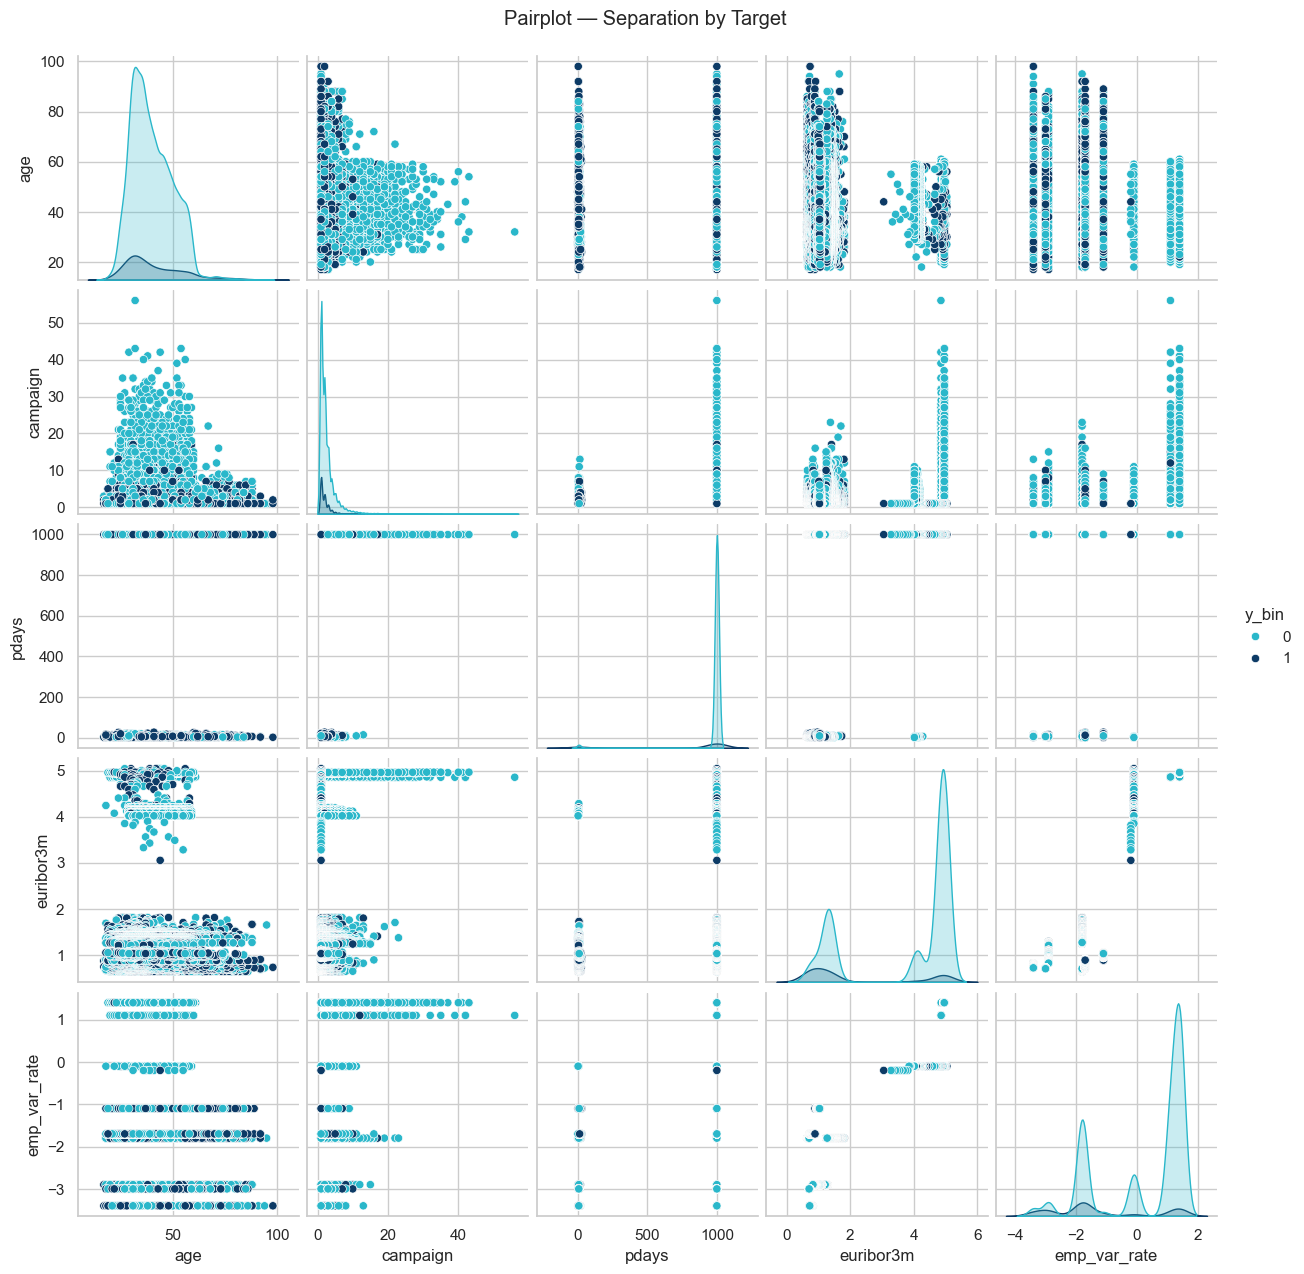

In [57]:
target_pairplot_cols = [
    "age", "campaign", "pdays", "euribor3m", "emp_var_rate"
]

g = sns.pairplot(
    df[target_pairplot_cols + ["y_bin"]],
    hue="y_bin",
    kind="scatter",
    palette={0: ACCENT_COLOR, 1: SECOND_COLOR},
    diag_kind="kde",
    corner=False
)

g.fig.suptitle("Pairplot — Separation by Target", y=1.02)

plt.savefig(f"{FIG_DIR}pairplot_target.png", dpi=300, bbox_inches="tight")
plt.show()
